In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullFormatter
import numpy as np
import copy as copy
from IPython import display
import gc
plt.rcParams['figure.figsize'] = (18, 15)
plt.rcParams['font.size'] = 32

In [2]:
from matplotlib.ticker import FuncFormatter
# ##########################################################
# Format tick labels using their exponent only... 
# ##########################################################
def formatter(x,pos):
    return format(np.log10(x), '.0f')

In [3]:
# ##########################################################
# Generate colors for histogram bars based on a normalized
# height. Normalize by bin width and comoving vol
# Method:
#  Take log of the histogram values (weighted counts)..
#  Create a LogNorm mapping between 1->max
#  Use the norm to map scalar values between 1 & max to rgb
# ##########################################################
def colorHistOnHeight(N, bins, patches, cmvol, minc, maxc):
    cleanN = np.ma.masked_where(N == 0.0, N)
    widths = np.diff(np.log10(bins))
    fracs  = np.log10(cleanN/widths/cmvol)

    # normalize colors to the top of our scale
    norm   = mpl.colors.LogNorm(vmin=minc, vmax=maxc) 
    sm     = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
    sm.set_clim([minc, maxc]) # Force to use the whole range
    for thisfrac, thispatch in zip(fracs, patches):
        color = sm.to_rgba(thisfrac)
        thispatch.set_facecolor(color)
    return 
# ##########################################################
# Normalizes the histogram's bar height by the bin width
# and comoving volume of the simulation
# ##########################################################
def normBarHeight(bins, patches, cmvol, rotated=False):
    widths = np.diff(np.log10(bins))
    #print ("patches %i, bins %i"%(len(patches),len(widths)))
    for item,dbx in zip(patches,widths):
        #print ("Starting height: %.2f bin width: %.2e"%(item.get_height(),dbx))
        if not rotated:
            item.set_height(item.get_height()/dbx/cmvol)
        else:
            item.set_width(item.get_width()/dbx/cmvol)
        #print ("Ending width: %.2f"%item.get_width())
    return

In [146]:
custom_formatter = FuncFormatter(formatter)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_2dhist = [left, bottom, width, height]
rect_histx = [left, bottom_h, width - 0.13, 0.15]
rect_histy = [left_h, bottom, 0.15, height]
labelsize = 34

In [5]:
prefix = "./"
z = "05.00"
locs   = np.loadtxt(prefix + "spLoc_" + z + ".txt", skiprows=1)
masses = np.loadtxt(prefix + "spMass_" + z + ".txt", skiprows=1)
spZ  = np.loadtxt(prefix + "spZ_" + z + ".txt", skiprows=1)
spPZ = np.loadtxt(prefix + "spPZ_" + z + ".txt", skiprows=1)
spPF = np.loadtxt(prefix + "spPPF_" + z + ".txt", skiprows=1)

In [6]:
fpol = (1-spPF)
fpol[fpol<1e-6] = 0 # Don't let tiny numbers magnify Z !! Just use Z = 0 for these guys
### Does it make sense to have fpol < 10^-4 or so since our average star particle is 750 M_sun?? Once you are below
### .1 solar mass this doesn't represent an enhanced pollution of a single star, but enhanced pollution of a 
### single star 
# Do the correcting before fixing Z for subcritical values... otherwise, we bias Z/f_pol
Zf=spZ/fpol # This is our Z corrected for f_pol
Zf[np.isinf(Zf)] = 10**-8.5 # Fix Zf for sp's with very very low polluted fractions. They are essentially pristine
Zf[np.isnan(Zf)] = 10**-8.5
#Zf[Zf<1e-5] = 10**-7.5

PZf=spPZ/fpol
PZf[np.isinf(PZf)] = 10**-8.5
PZf[np.isnan(PZf)] = 10**-8.5

/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide


In [165]:
# Determine which stars are completely primordial (PM) at this redshift.
spZmPZCond = (Zf - PZf)
priStars = (spZmPZCond == 0.0) # This is a conditional check. Selects star particles with only PM
mixedStar = (spZmPZCond > 0.0) # Select stars with both primordial and regular metals

## 25 M_sun Pop III SN mass fractions, Nomoto
<|H -> 67.2466, He -> 36.2852, 
 C -> 0.864672, N -> 0.00100878, O -> 0.13237, 
 F -> 7.35231*10^-10, Ne -> 0.00181426, Na -> 1.07003*10^-7, 
 Mg -> 0.0000405398, Al -> 1.28539*10^-7, Si -> 0.0000242565, 
 P -> 6.74577*10^-9, S -> 0.0000142174, Cl -> 9.36997*10^-9, 
 Ar -> 2.68986*10^-6, K -> 2.81018*10^-9, Ca -> 3.71304*10^-6, 
 Sc -> 2.69701*10^-11, Ti -> 5.73999*10^-8, V -> 2.31868*10^-9, 
 Cr -> 9.63105*10^-7, Mn -> 1.57773*10^-7, Fe -> 0.0000474087, 
 Co -> 3.87723*10^-8, Ni -> 6.47289*10^-7|>
 ## 60 M_sun Pop III SN mass fractions, Heger
 <|H -> 787.904, He -> 636.082, 
 C -> 0.711729, N -> 0.000949252, O -> 0.273221, 
 F -> 1.7175*10^-6, Ne -> 0.0131384, Na -> 1.89183*10^-6, 
 Mg -> 0.000956191, Al -> 8.26108*10^-7, Si -> 2.18676*10^-6, 
 P -> 1.62811*10^-8, S -> 3.13468*10^-8, Cl -> 3.07894*10^-10, 
 Ar -> 1.00391*10^-9, K -> 3.7441*10^-10, Ca -> 1.43246*10^-7, 
 Sc -> 5.0064*10^-12, Ti -> 2.45711*10^-11, V -> 1.49119*10^-12, 
 Cr -> 5.15296*10^-12, Mn -> 2.86712*10^-13, Fe -> 2.63816*10^-12, 
 Co -> 3.32158*10^-13, Ni -> 1.77383*10^-12|>
 
## Sun's mass fractions, X_{i,sun}
 Use these values when modeling solar metal fractions
 Solar values based on Asplund
<|H -> 0.735999, He -> 0.250575, 
 C -> 0.00237716, N -> 0.000696635, O -> 0.00576763, 
 F -> 5.07728*10^-7, Ne -> 0.00125287, Na -> 0.0000294175, 
 Mg -> 0.000703216, Al -> 0.0000560069, Si -> 0.000666861, 
 P -> 5.86461*10^-6, S -> 0.000310476, Cl -> 8.14602*10^-6, 
 Ar -> 0.0000739499, K -> 3.07569*10^-6, Ca -> 0.0000644076, 
 Sc -> 4.67832*10^-8, Ti -> 3.14861*10^-6, V -> 3.19483*10^-7, 
 Cr -> 0.0000167063, Mn -> 0.0000108953, Fe -> 0.00130336, 
 Co -> 4.24355*10^-6, Ni -> 0.0000708444|>
 ## Asplunds's solar metal mass fractions -- based on solar metals only
  Only use elements C, N, O, ... These are metal fractions: i.e. - X/Sum(X_i,{X_c,X_ni})
  Only need to use these if I want to scale my Z's to the sun's fractions
<|H -> 54.8198, He -> 18.6637, 
 C -> 0.177059, N -> 0.0518878, O -> 0.273221, 
 F -> 0.0000378173, Ne -> 0.0933184, Na -> 0.00219112, Mg -> 0.052378,
  Al -> 0.00417159, Si -> 0.0496701, P -> 0.000436817, S -> 0.0231253,
  Cl -> 0.000606744, Ar -> 0.00550804, K -> 0.000229088, 
 Ca -> 0.00479731, Sc -> 3.48458*10^-6, Ti -> 0.000234519, 
 V -> 0.0000237962, Cr -> 0.00124434, Mn -> 0.000811522, 
 Fe -> 0.097079, Co -> 0.000316074, Ni -> 0.00527674|>

In [167]:
# Metal Mass-fractions for 25 M_sun Pop III SN
C25sn = 0.864672; N25sn =0.00100878; O25sn = 0.13237; Mg25sn = 0.0000405398; Ca25sn = 3.71304e-6;Fe25sn = 0.0000474087;
# Metal Mass-fractions for 60 M_sun Pop III SN - Heger, StarFit.org and Keller SMSS J031300.362670839.3 obs data
C60sn = 0.711729; N60sn =0.000949252; O60sn = 0.273221; Mg60sn = 0.000956191; Ca60sn = 1.43246e-7;Fe60sn = 2.63816e-12;
# Metal Mass-fractions for 1 Gyr ave ejecta - Franks model
Cf = 0.168153 ; Nf =0.0792975; Of = 0.528584 ; Mgf=0.0249245; Caf=0.00300647 ;Fef = 0.0539277;

# Solar metal mass fractions based on Asplund's solar abundances - use to scale my Z's to solar fraction
# if I want a component of the star to map to solar metallicity (by Asplund)
Csunmetal = 0.177059; Nsunmetal =0.0518878; Osunmetal = 0.429593; Mgsunmetal= 0.052378; Casunmetal=0.00479731;Fesunmetal = 0.097079; 
# Used to normalize the mass fractions and convert to number densities.
Csun = 0.00237716; Nsun =0.000696635; Osun = 0.00576763; Mgsun=0.000703216; Casun=0.0000644076; Fesun = 0.00130336; 

In [168]:
# Compute fractions of PM based on 25 M_sun Pop III SN abundances 
# spPZ is already in solar units (i.e. if spPZ = 1.0 we have solar metallicity for that star particle),
# so convert spPZ back to mass fraction first. 
# What we're doing: (Z_P * 0.02) * X_sn results in the mass fraction of that element as if it came from that SN
CH = PZf[priStars] * 0.02 * C25sn
NH = PZf[priStars] * 0.02 * N25sn
OH = PZf[priStars] * 0.02 * O25sn
MgH = PZf[priStars] * 0.02 * Mg25sn
CaH = PZf[priStars] * 0.02 * Ca25sn
FeH = PZf[priStars] * 0.02 * Fe25sn

# Mass fractions of the elements in our primordial metals ... mass-fraction of metals units
C60 = PZf[priStars] * 0.02 * C60sn
N60 = PZf[priStars] * 0.02 * N60sn
O60 = PZf[priStars] * 0.02 * O60sn
Mg60 = PZf[priStars] * 0.02 * Mg60sn
Ca60 = PZf[priStars] * 0.02 * Ca60sn
Fe60 = PZf[priStars] * 0.02 * Fe60sn

In [169]:
# For stars with regular Z and PZ, assume solar composition for regular Z, and the yields from a 25 M Pop III SN
# for the PM part. 
CH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Csunmetal + PZf[mixedStar] * 0.02 * C25sn
NH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Nsunmetal + PZf[mixedStar] * 0.02 * N25sn
OH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Osunmetal + PZf[mixedStar] * 0.02 * O25sn
FeH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Fesunmetal + PZf[mixedStar] * 0.02 * Fe25sn
MgH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Mgsunmetal + PZf[mixedStar] * 0.02 * Mg25sn
CaH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Casunmetal + PZf[mixedStar] * 0.02 * Ca25sn
# Note that we if Osun and Csun, etc. were standard solar metal mass fractions I could just multiply Z by Csun,etc.
# However, since the Asplund data doesn't result in a 0.02 solar metal fraction, we need to normalize Z by 0.02 
# and then multiply by the Asplund metal fractions...
# 
# Next we should use Frank's results to scale the "regular Z" since it really isn't "regular", but Fe depleted.
#
CH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Cf + PZf[mixedStar] * 0.02 * C25sn
NH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Nf + PZf[mixedStar] * 0.02 * N25sn
OH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Of + PZf[mixedStar] * 0.02 * O25sn
MgH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Mgf + PZf[mixedStar] * 0.02 * Mg25sn
CaH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Caf + PZf[mixedStar] * 0.02 * Ca25sn
FeH_mixedF25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Fef + PZf[mixedStar] * 0.02 * Fe25sn

# Use Franks for normal and Heger 60 M_sun or primordial.
#
C_mixedF60  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Cf + PZf[mixedStar] * 0.02 * C60sn
N_mixedF60  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Nf + PZf[mixedStar] * 0.02 * N60sn
O_mixedF60  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Of + PZf[mixedStar] * 0.02 * O60sn
Mg_mixedF60 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Mgf + PZf[mixedStar] * 0.02 * Mg60sn
Ca_mixedF60 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Caf + PZf[mixedStar] * 0.02 * Ca60sn
Fe_mixedF60 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Fef + PZf[mixedStar] * 0.02 * Fe60sn


In [170]:
# Keller data
CHFeH = np.loadtxt("/Users/earnric/Copy/Research-PristineGas/Write-up/Keller star data/CH-FeH.txt", skiprows=1);
OHFeH = np.loadtxt("/Users/earnric/Copy/Research-PristineGas/Write-up/Keller star data/OH-FeH Keller.txt", skiprows=1);
MgCaFeH = np.loadtxt("/Users/earnric/Copy/Research-PristineGas/Write-up/Keller star data/MgCa-FeH Keller.txt", skiprows=1);

In [171]:
print("Mass fractions")
print("60M SN Mg=%.2e  Ca=%.2e  Fe=%.2e"%(Mg60sn,Ca60sn,Fe60sn))
print("Sun    Mg=%.2e  Ca=%.2e  Fe=%.2e"%(Mgsun,Casun,Fesun))
print("Frank  Mgf=%.2e Caf=%.2e Fef=%.2e"%(Mgf,Caf,Fef))
print("All SN Mgf=%.2e Caf=%.2e Fef=%.2e"%((Mg60sn)/Mgsun,Ca60sn/Casun,Fe60sn/Fesun))
print('Mixed 10%% Frank and 90%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.1*Mgf+.9*Mg60sn)/Mgsun, (.1*Caf+.9*Ca60sn)/Casun, (.1*Fef+.9*Fe60sn)/Fesun))
print('Mixed 20%% Frank and 80%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.2*Mgf+.8*Mg60sn)/Mgsun, (.2*Caf+.8*Ca60sn)/Casun, (.2*Fef+.8*Fe60sn)/Fesun))
print('Mixed 30%% Frank and 70%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.3*Mgf+.7*Mg60sn)/Mgsun, (.3*Caf+.7*Ca60sn)/Casun, (.3*Fef+.7*Fe60sn)/Fesun))
print('Mixed 40%% Frank and 60%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.4*Mgf+.6*Mg60sn)/Mgsun, (.4*Caf+.6*Ca60sn)/Casun, (.4*Fef+.6*Fe60sn)/Fesun))
print('Mixed 50%% Frank and 50%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.5*Mgf+.5*Mg60sn)/Mgsun, (.5*Caf+.5*Ca60sn)/Casun, (.5*Fef+.5*Fe60sn)/Fesun))

Mass fractions
60M SN Mg=9.56e-04  Ca=1.43e-07  Fe=2.64e-12
Sun    Mg=7.03e-04  Ca=6.44e-05  Fe=1.30e-03
Frank  Mgf=2.49e-02 Caf=3.01e-03 Fef=5.39e-02
All SN Mgf=1.36e+00 Caf=2.22e-03 Fef=2.02e-09
Mixed 10% Frank and 90% 60M SN, solar units: Mg=4.77e+00 Ca=4.67e+00 Fe=4.14e+00
Mixed 20% Frank and 80% 60M SN, solar units: Mg=8.18e+00 Ca=9.34e+00 Fe=8.28e+00
Mixed 30% Frank and 70% 60M SN, solar units: Mg=1.16e+01 Ca=1.40e+01 Fe=1.24e+01
Mixed 40% Frank and 60% 60M SN, solar units: Mg=1.50e+01 Ca=1.87e+01 Fe=1.66e+01
Mixed 50% Frank and 50% 60M SN, solar units: Mg=1.84e+01 Ca=2.33e+01 Fe=2.07e+01


In [172]:
((.3*Mgf+.7*Mg60sn)/Mgsun/((.3*Caf+.7*Ca60sn)/Casun))/((.3*Fef+.7*Fe60sn)/Fesun),  
((.5*Mgf+.5*Mg60sn)/Mgsun/((.5*Caf+.5*Ca60sn)/Casun)/ ((.5*Fef+.5*Fe60sn)/Fesun))

0.03810914102703246

In [173]:
temp=(Mg_mixedF60/Mgsun)/(Ca_mixedF60/Casun)
print(len(temp[temp<0.5]))

0


3784431


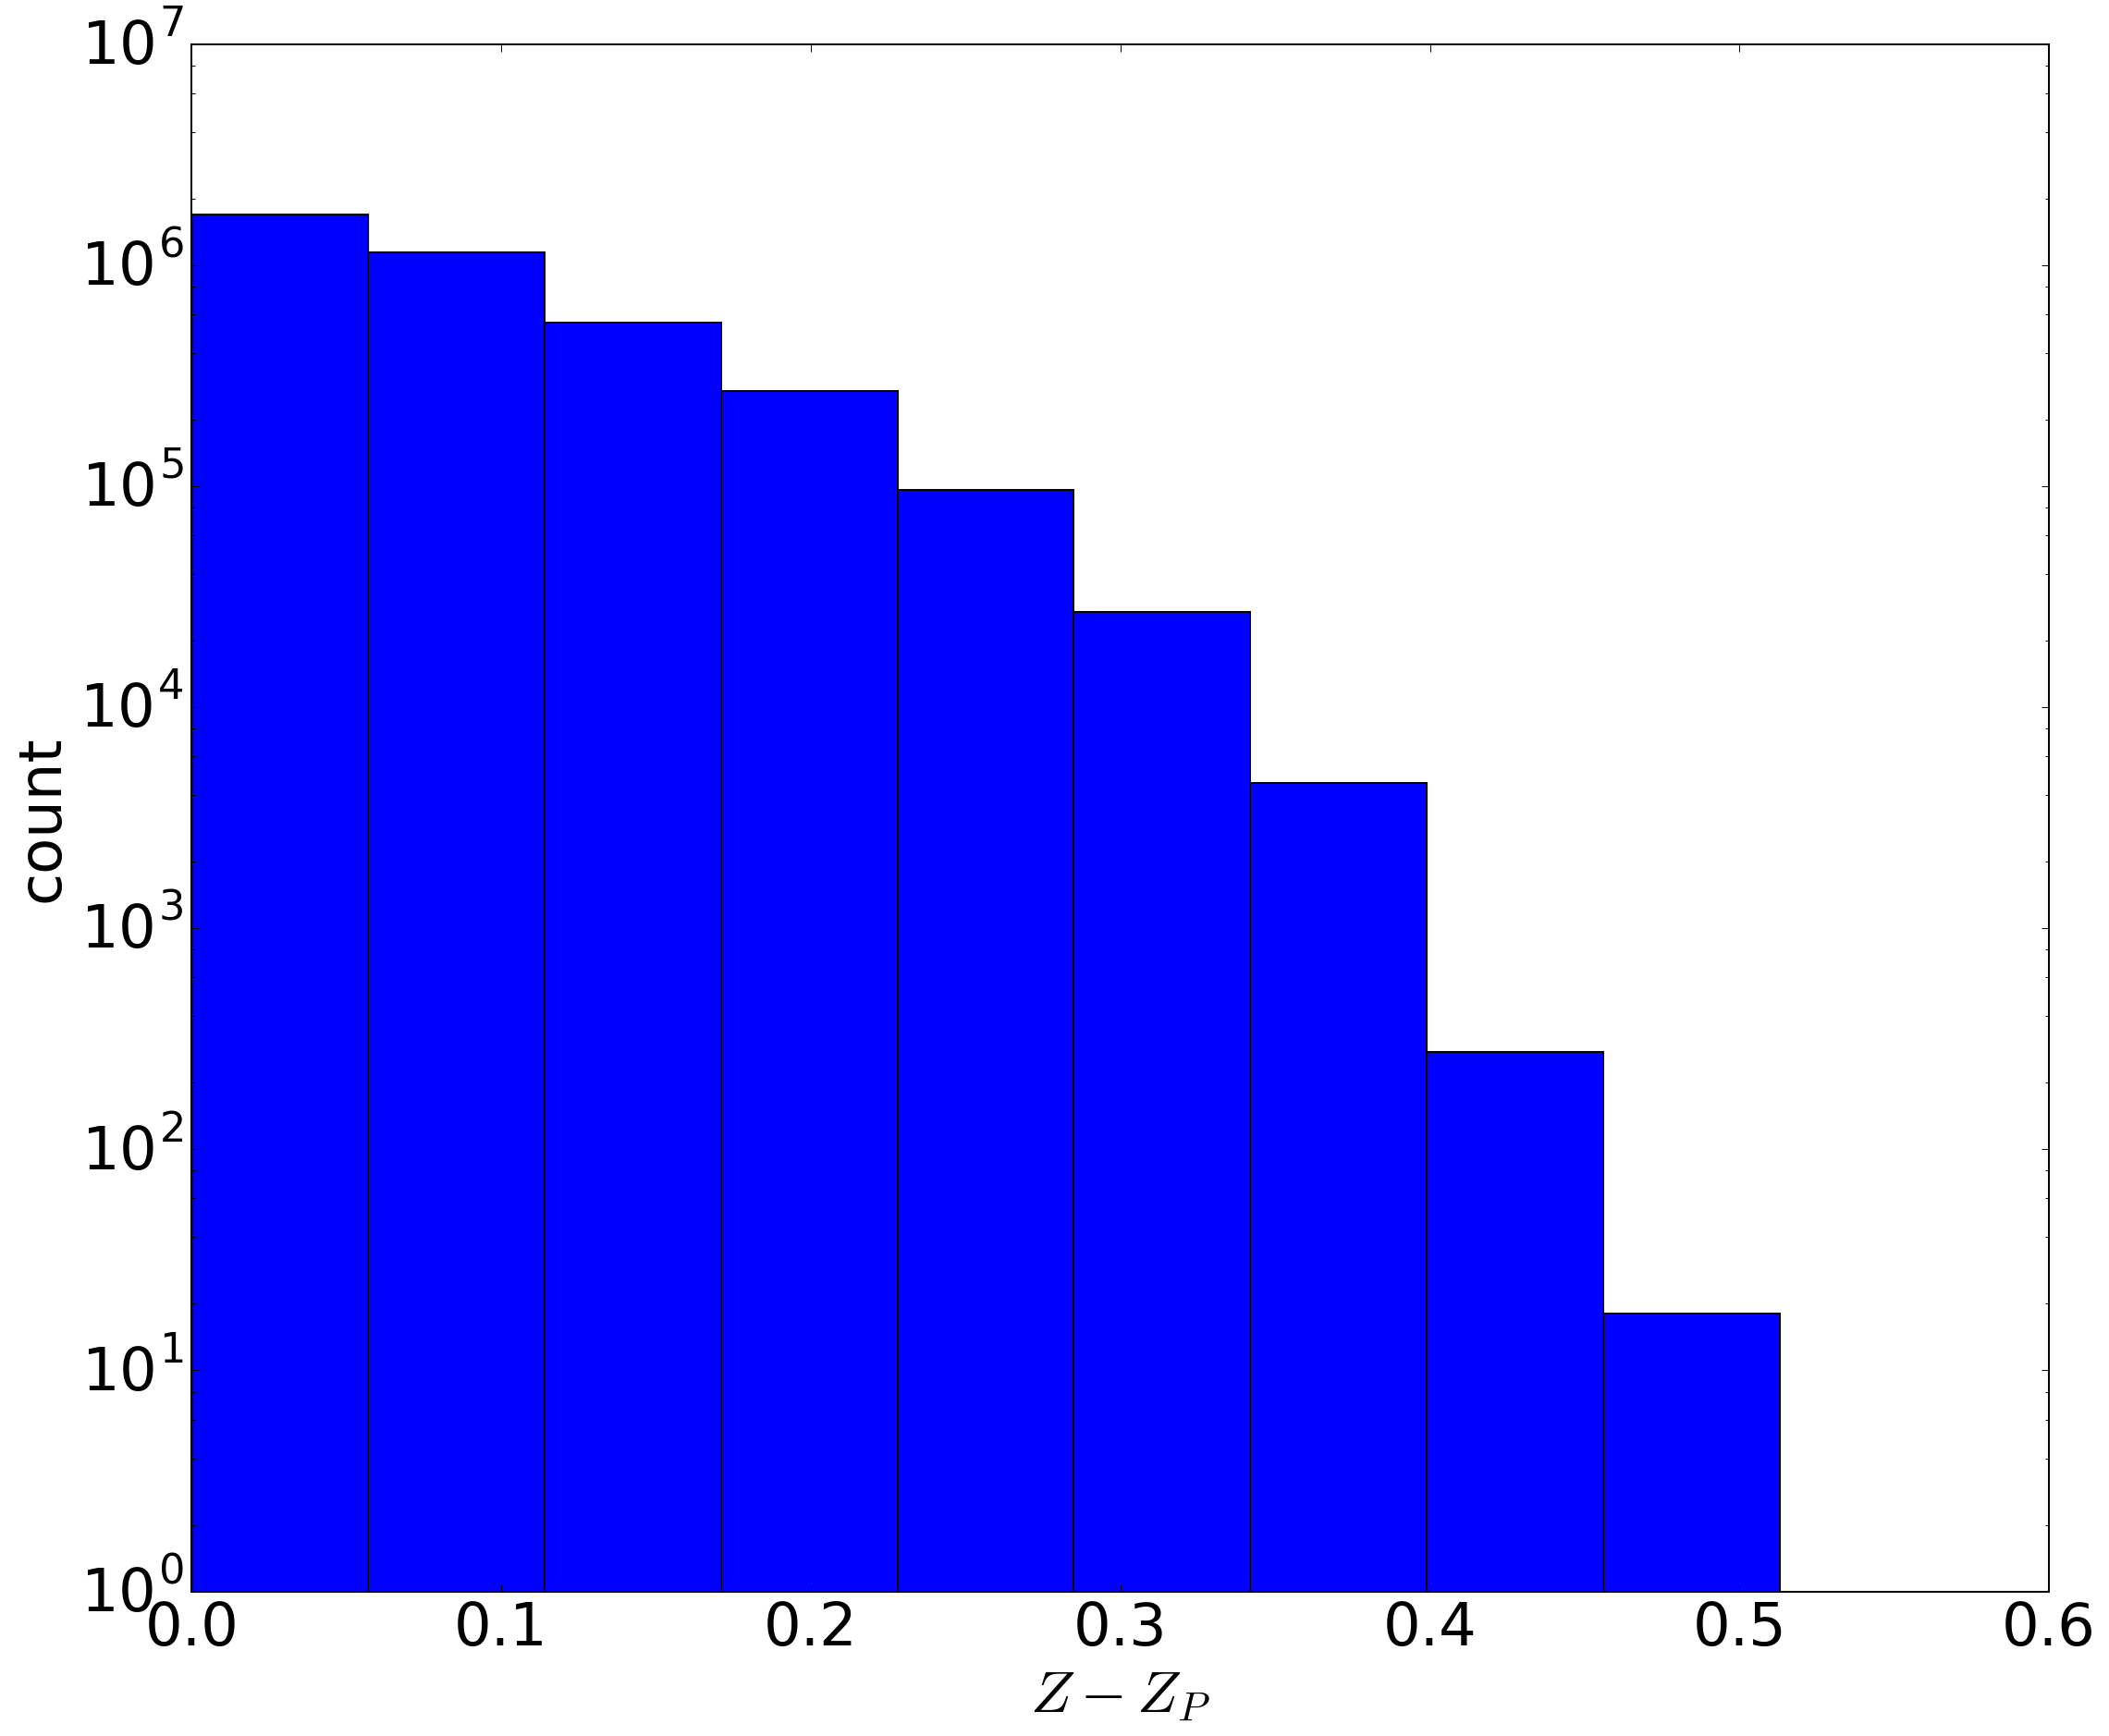

In [118]:
print(len(Zf[mixedStar]-PZf[mixedStar]))
plt.hist(Zf[mixedStar]-PZf[mixedStar], log=True)
plt.xlabel("$Z-Z_P$")
plt.ylabel("count")

In [174]:
print('Mgmixed=%.2e Camixed=%.2e Femix=%.2e'%(np.min(Mg_mixedF60),np.min(Ca_mixedF60),np.min(Fe_mixedF60)))

Mgmixed=6.46e-10 Camixed=1.39e-13 Femix=7.71e-18


In [175]:
# The O values are upper bounds. Need error bars for them in plots
Oindices=[[0,1],[2*4,2*4+1],[2*5,2*5+1],[2*8,2*8+1],[2*11,2*11+1],[2*12,2*12+1],[2*15,2*15+1]]

cmvol = 27.0 / (0.71)**3 # We're 'per h' so the volume is bigger than 27 Mpc^3

In [176]:
temp=(Mg_mixedF60/Mgsun)/(Ca_mixedF60/Casun)
len(temp[temp<0.0])

0

(array([  3.68782000e+06,   5.74600000e+03,   3.25500000e+03,
          2.20100000e+03,   1.77400000e+03,   1.42200000e+03,
          1.87700000e+03,   2.40100000e+03,   1.89500000e+03,
          7.60400000e+04]),
 array([   0.75931451,   61.8212836 ,  122.88325268,  183.94522176,
         245.00719084,  306.06915993,  367.13112901,  428.19309809,
         489.25506718,  550.31703626,  611.37900534]),
 <a list of 10 Patch objects>)

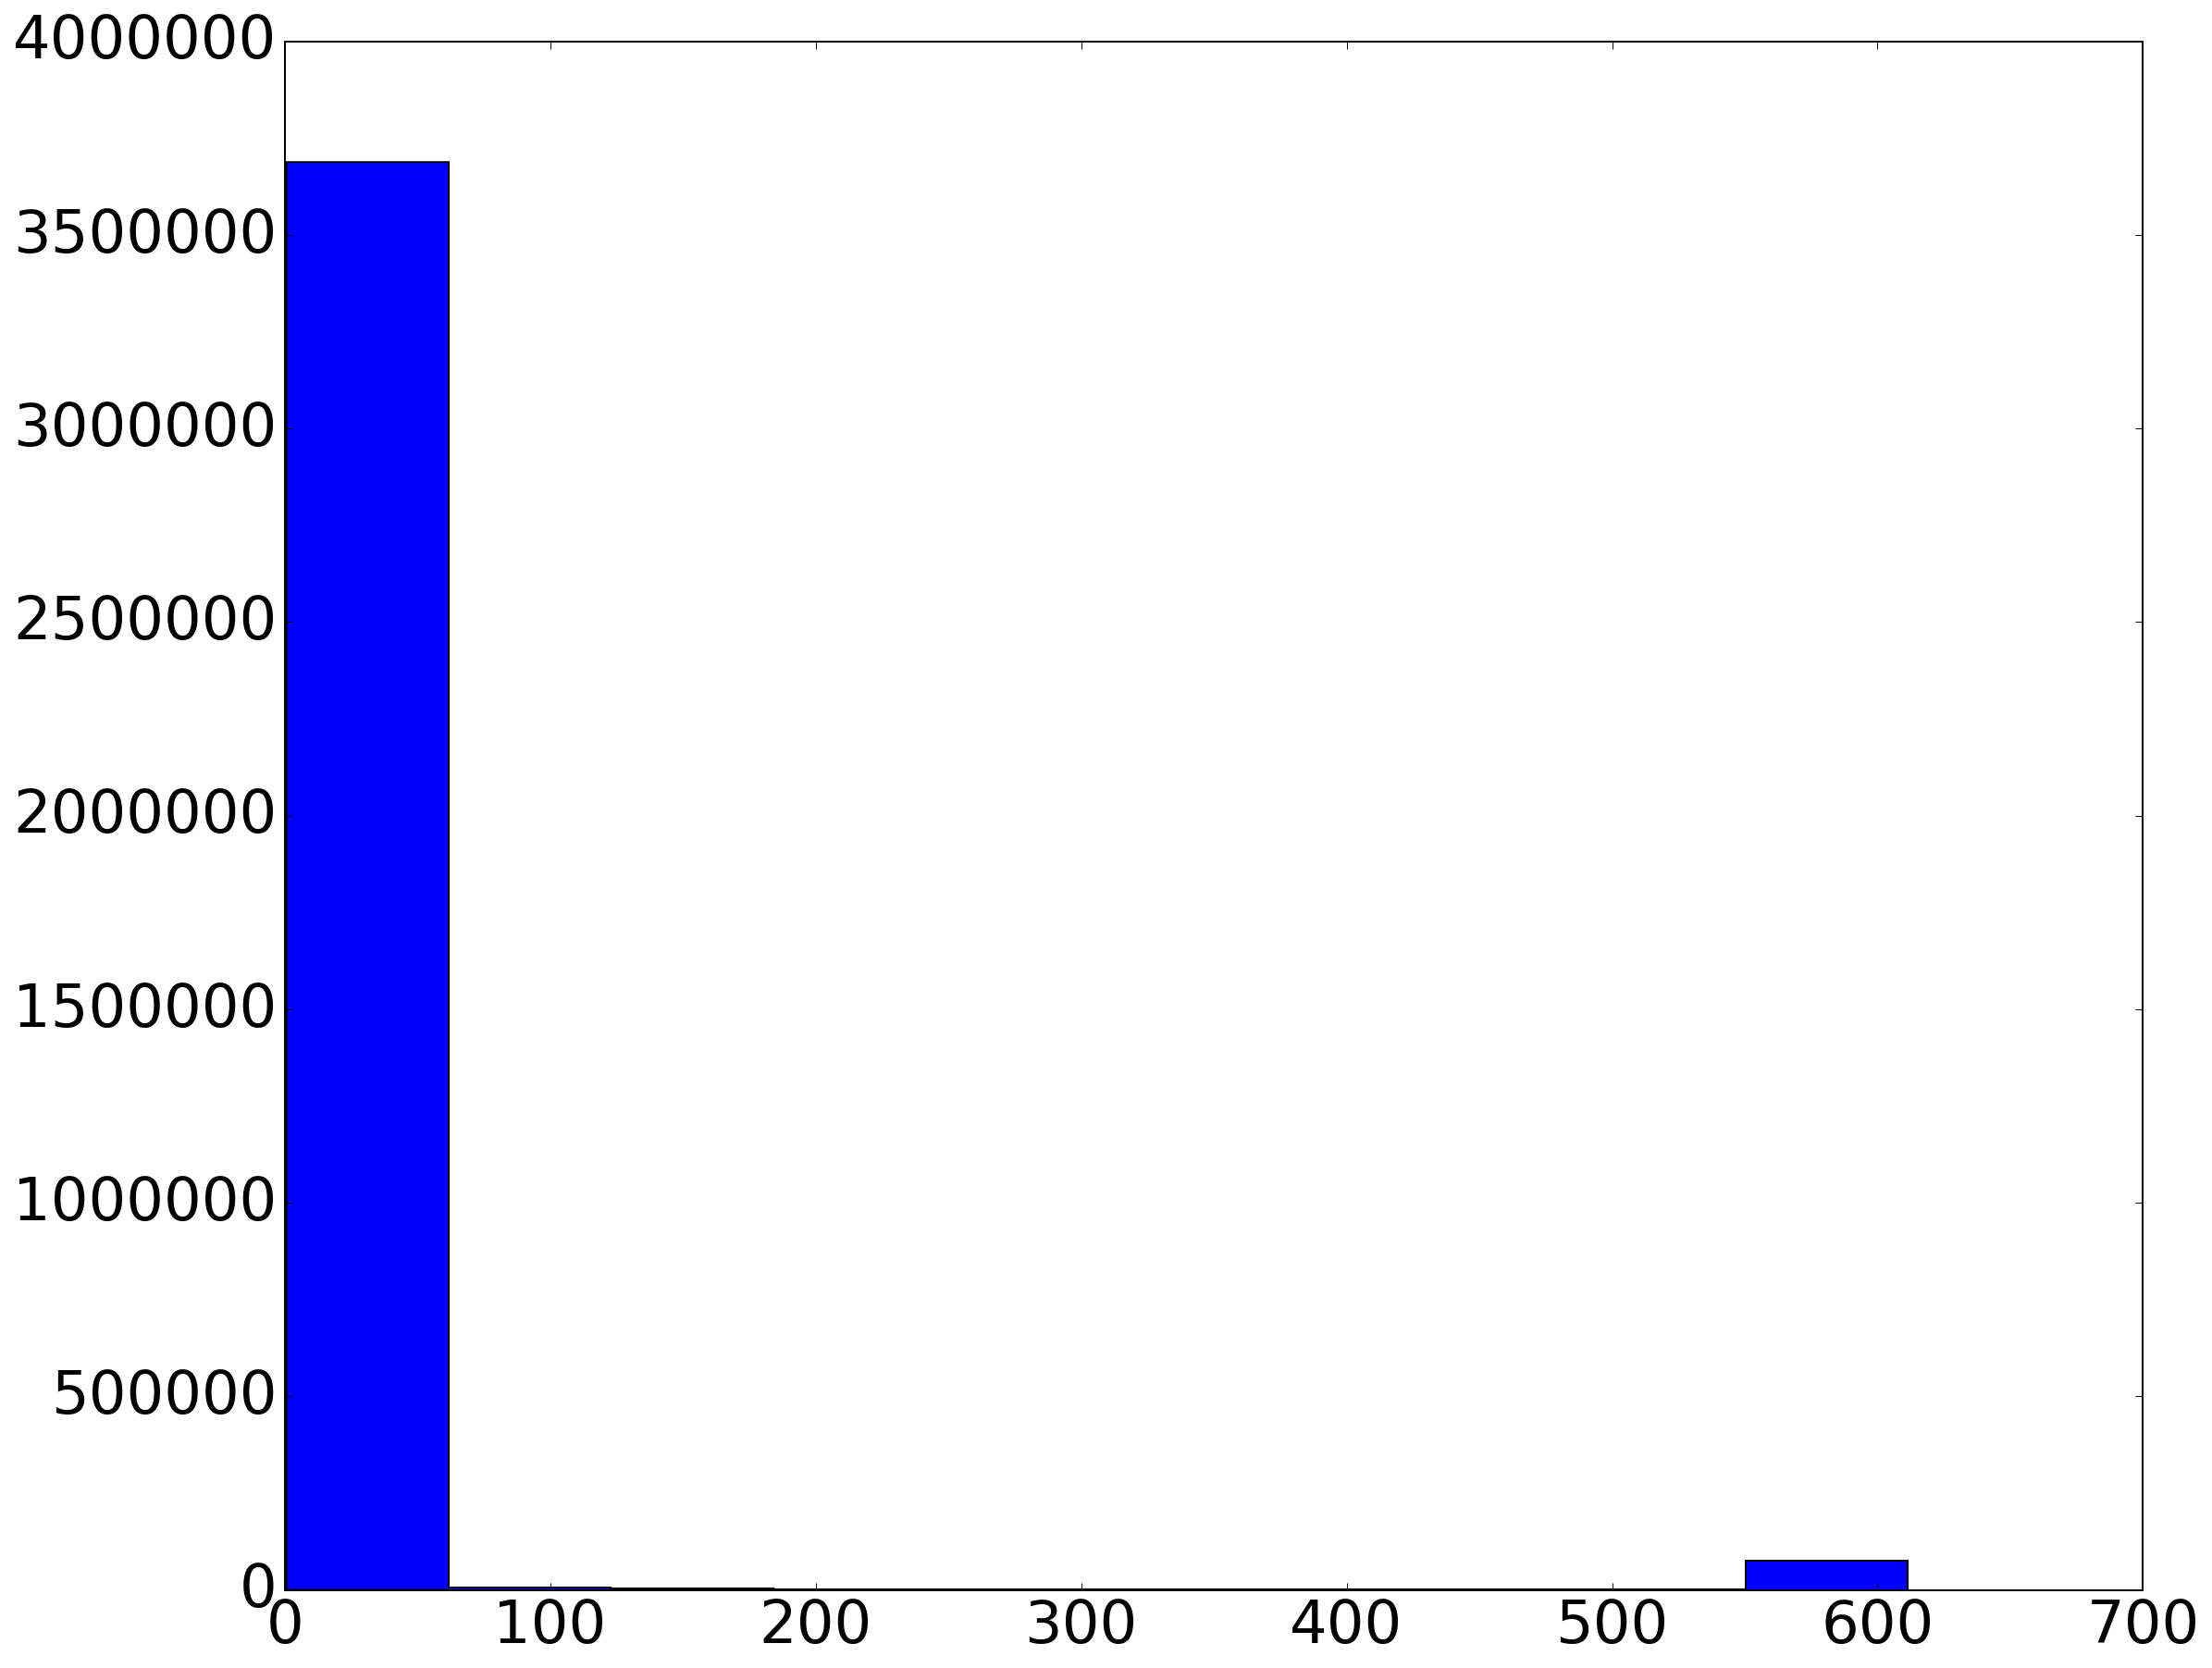

In [193]:
plt.hist((Mg_mixedF60/Mgsun)/(Ca_mixedF60/Casun))

/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


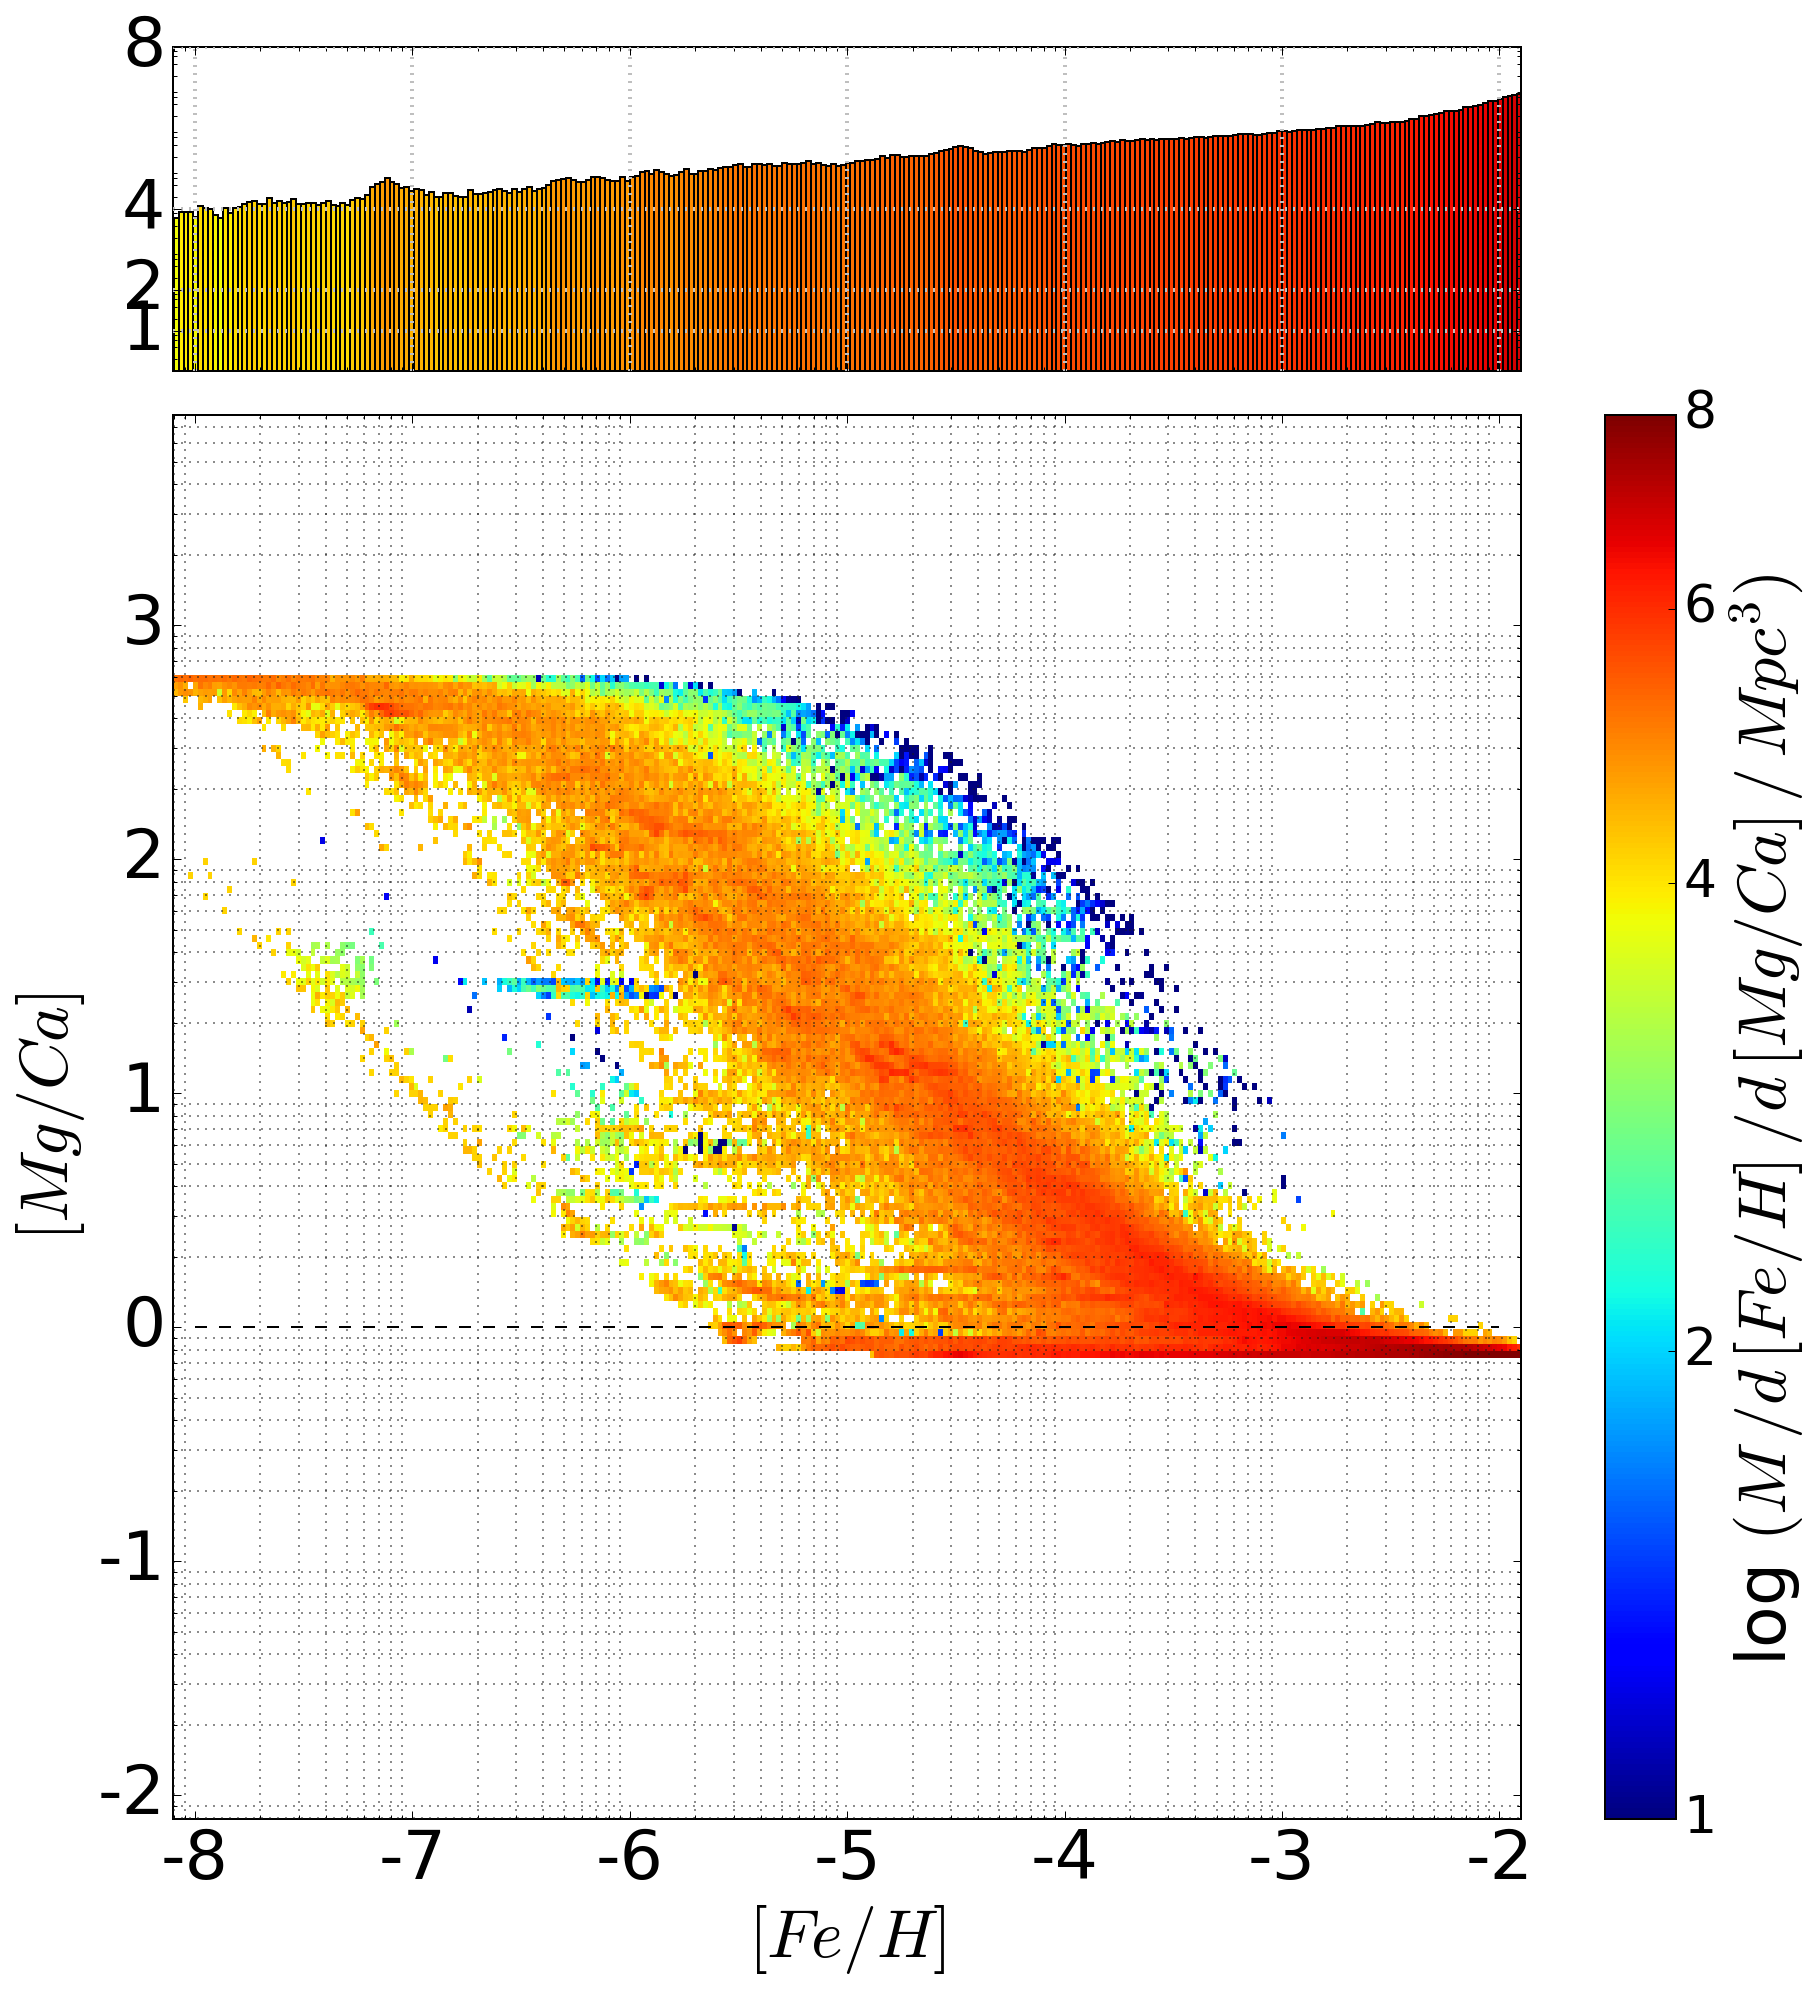

In [197]:
xrange = np.logspace(-9,0,400)
yrange = np.logspace(-9,3,400)

yLabel = "[Mg/Ca]"
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plot = "[O/H]"
H, xedges, yedges = np.histogram2d((Mg_mixedF60/Mgsun)/(Ca_mixedF60/Casun), (Fe_mixedF60/Fesun), 
                                    weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                    bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)

#axHisty = plt.axes(rect_histy)

nullfmt = NullFormatter()

minY = -2.1; maxY = 3.9
minX = -8.1; maxX = -1.9

histMax = 8
cbarMax = 8
cbarMin = 1

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([1e-8,1e-2]),np.array([1,1]), 'k--')

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax))) # pcolormesh transposes X,Y
cbarticks = [1,2,4,6,cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)

# Values should be along the 25 M_sun O yield line: [O/Fe] = 2.8

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, 
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([10.0**0.0,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e1,1e2, 1e4, 1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks


In [34]:
Fe_mixedF60/Fesun

array([ 0.03276431,  0.01963976,  0.01354559, ...,  0.03763729,
        0.04392598,  0.04322004])

In [130]:
temp=(Mg_mixedF60/Mgsun)-(Ca_mixedF60/Casun)
print(len(temp[temp<0]))
print(len(Fe_mixedF60/Fesun>0))
print(len(temp[temp>0]))

2769135
3784431
1015296


/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


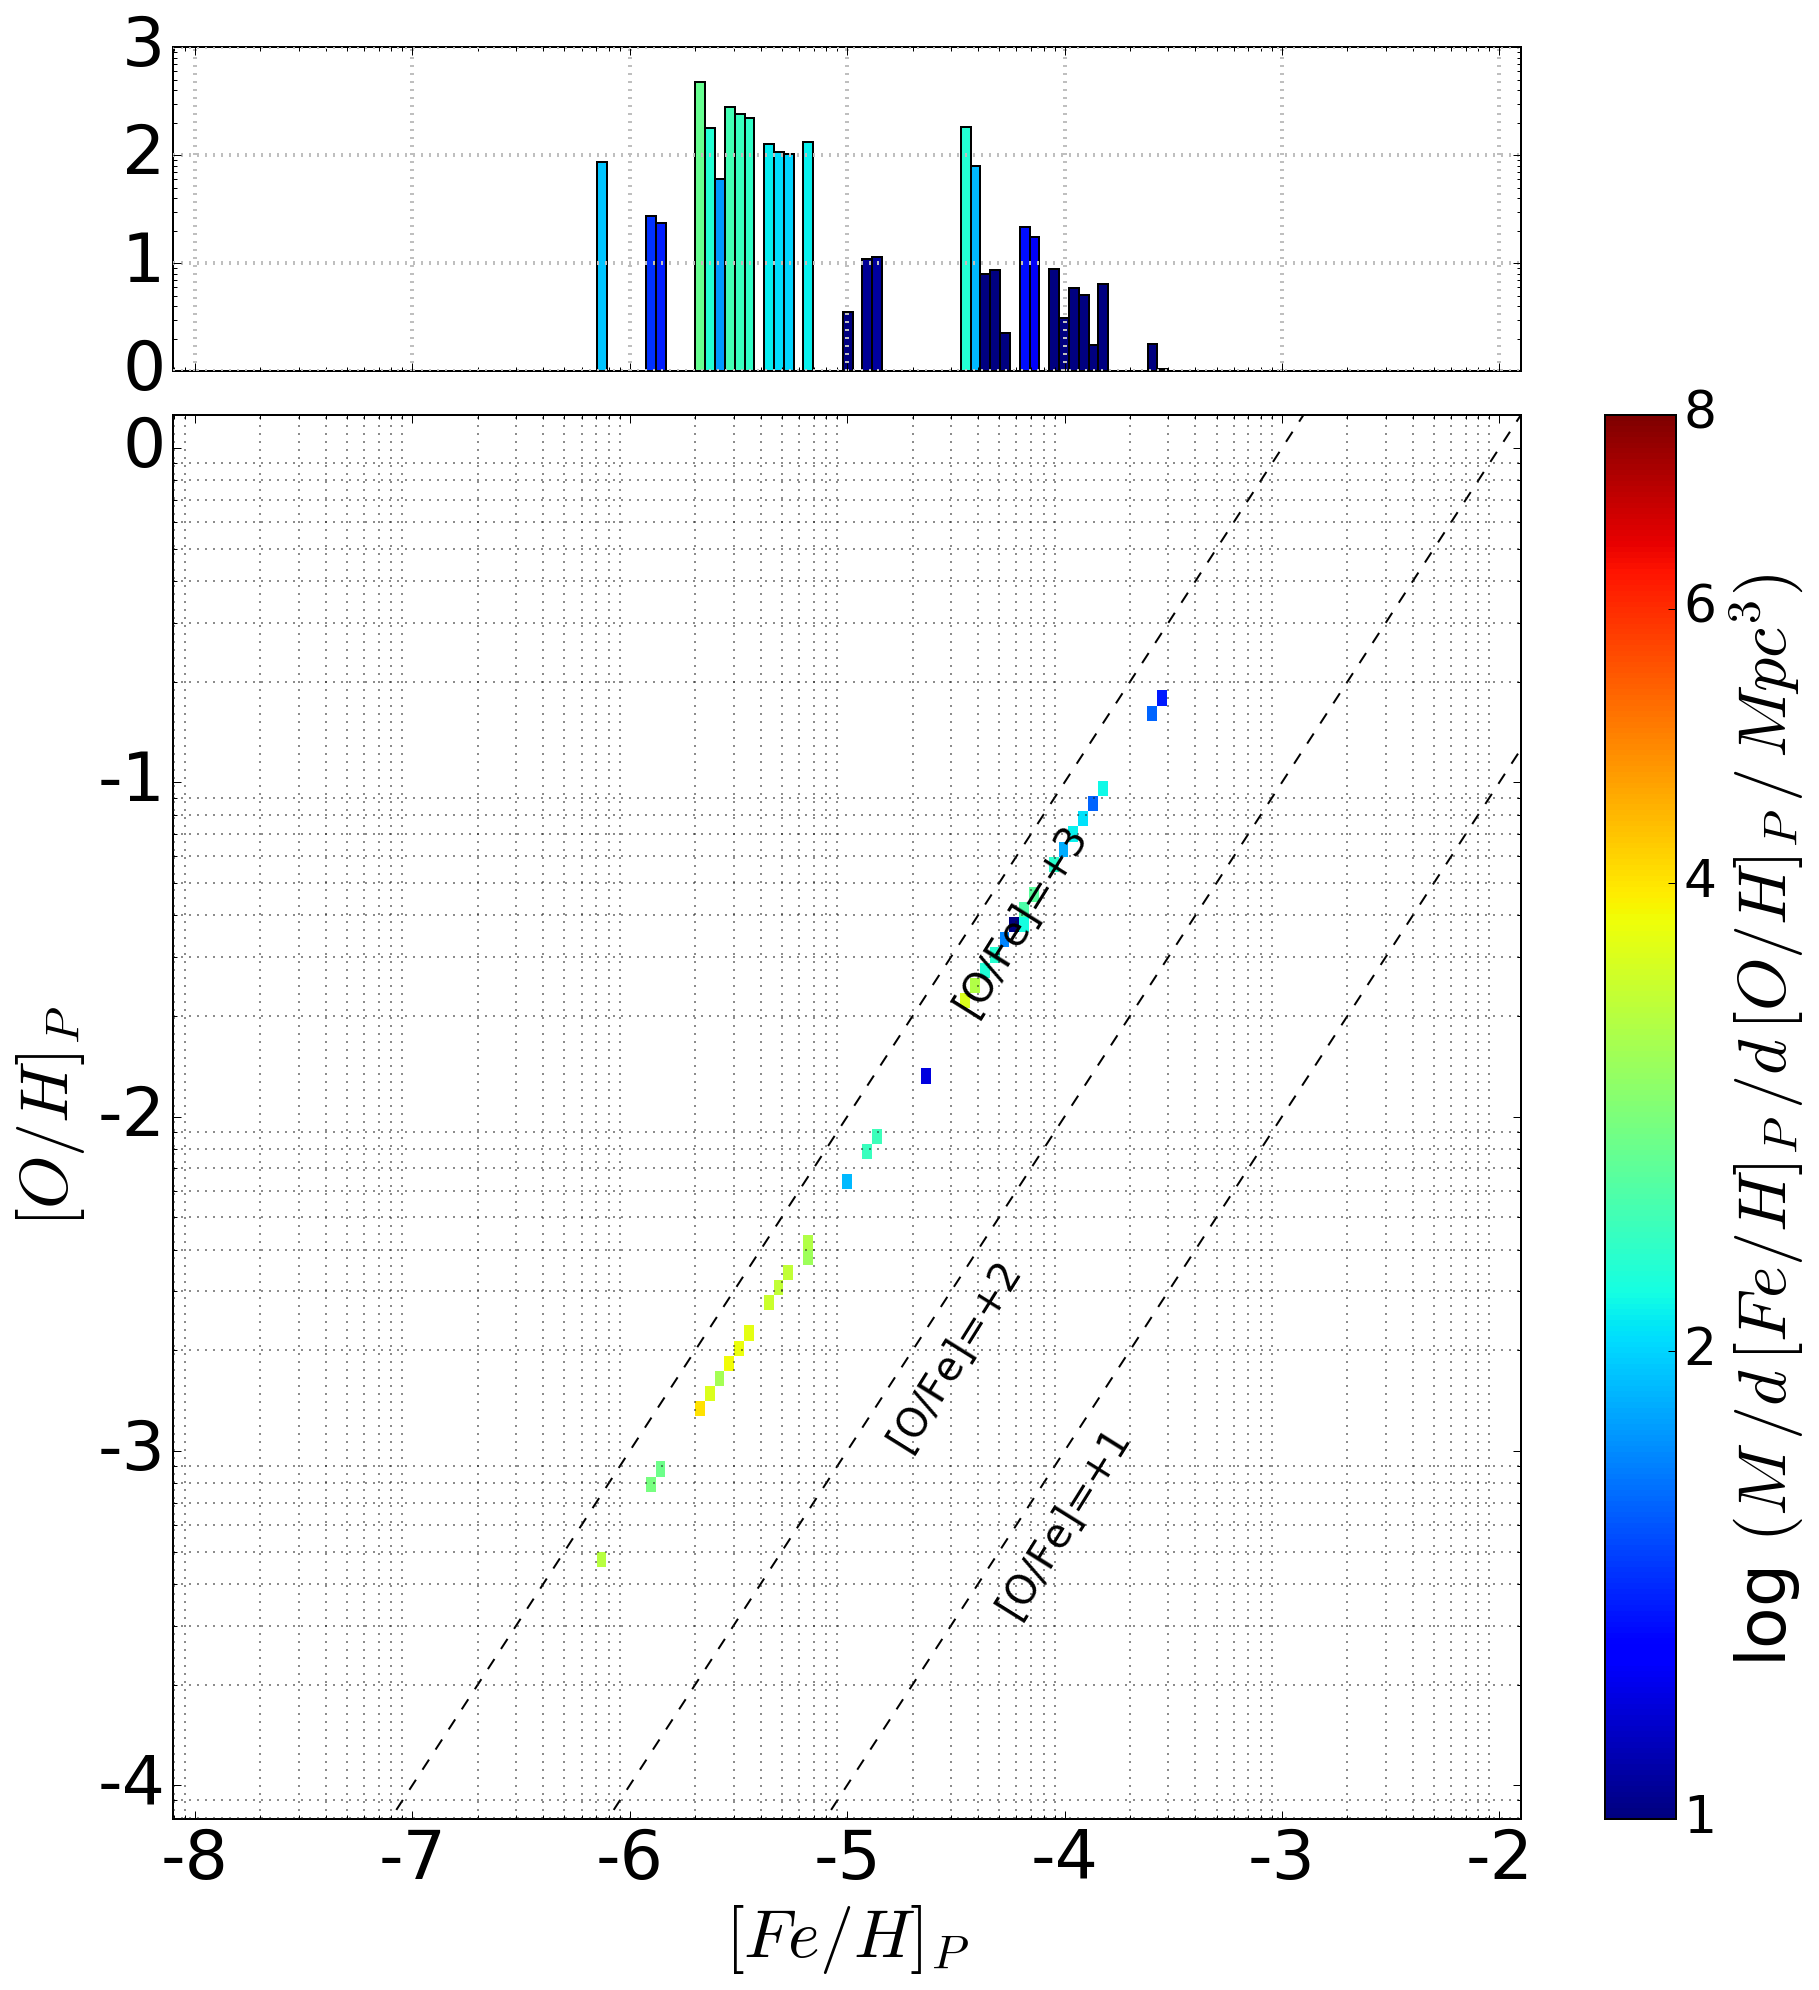

In [178]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
# Plot [O/H] vs [Fe/H]
yLabel = "[O/H]_{P}"
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plot = "[O/H]"
H, xedges, yedges = np.histogram2d(OH/Osun, FeH/Fesun, weights=masses[priStars] * (1.0 - spPF[priStars]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)

#axHisty = plt.axes(rect_histy)

nullfmt = NullFormatter()

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

histMax = 3
cbarMax = 8
cbarMin = 1

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{P}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[O/Fe]=+1', xy=(10**-6., 10**-4), xytext=(10**-4.0, 10**-3), 
                  horizontalalignment='center',size=20,rotation=58.0)
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+2', xy=(10**-6., 10**-4), xytext=(10**-4.5, 10**-2.50), 
                  horizontalalignment='center',size=20,rotation=58.0) 
cfeThree, = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6., 10**-4), xytext=(10**-4.2, 10**-1.2), 
                  horizontalalignment='center',size=20,rotation=58.0) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [1,2,4,6,cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{P}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)

# Values should be along the 25 M_sun O yield line: [O/Fe] = 2.8

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH/Fesun, bins=xrange, log=True, 
                                weights=masses[priStars] * (1.0 - spPF[priStars]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([10.0**0.0,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e0,1e1, 1e2, 1e3])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(OH/Osun, bins=yrange, log=True, weights=masses[priStars] * (1.0 - spPF[priStars]),
#                                        orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([10.0**0.7,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e1, 1e2, 1e3])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


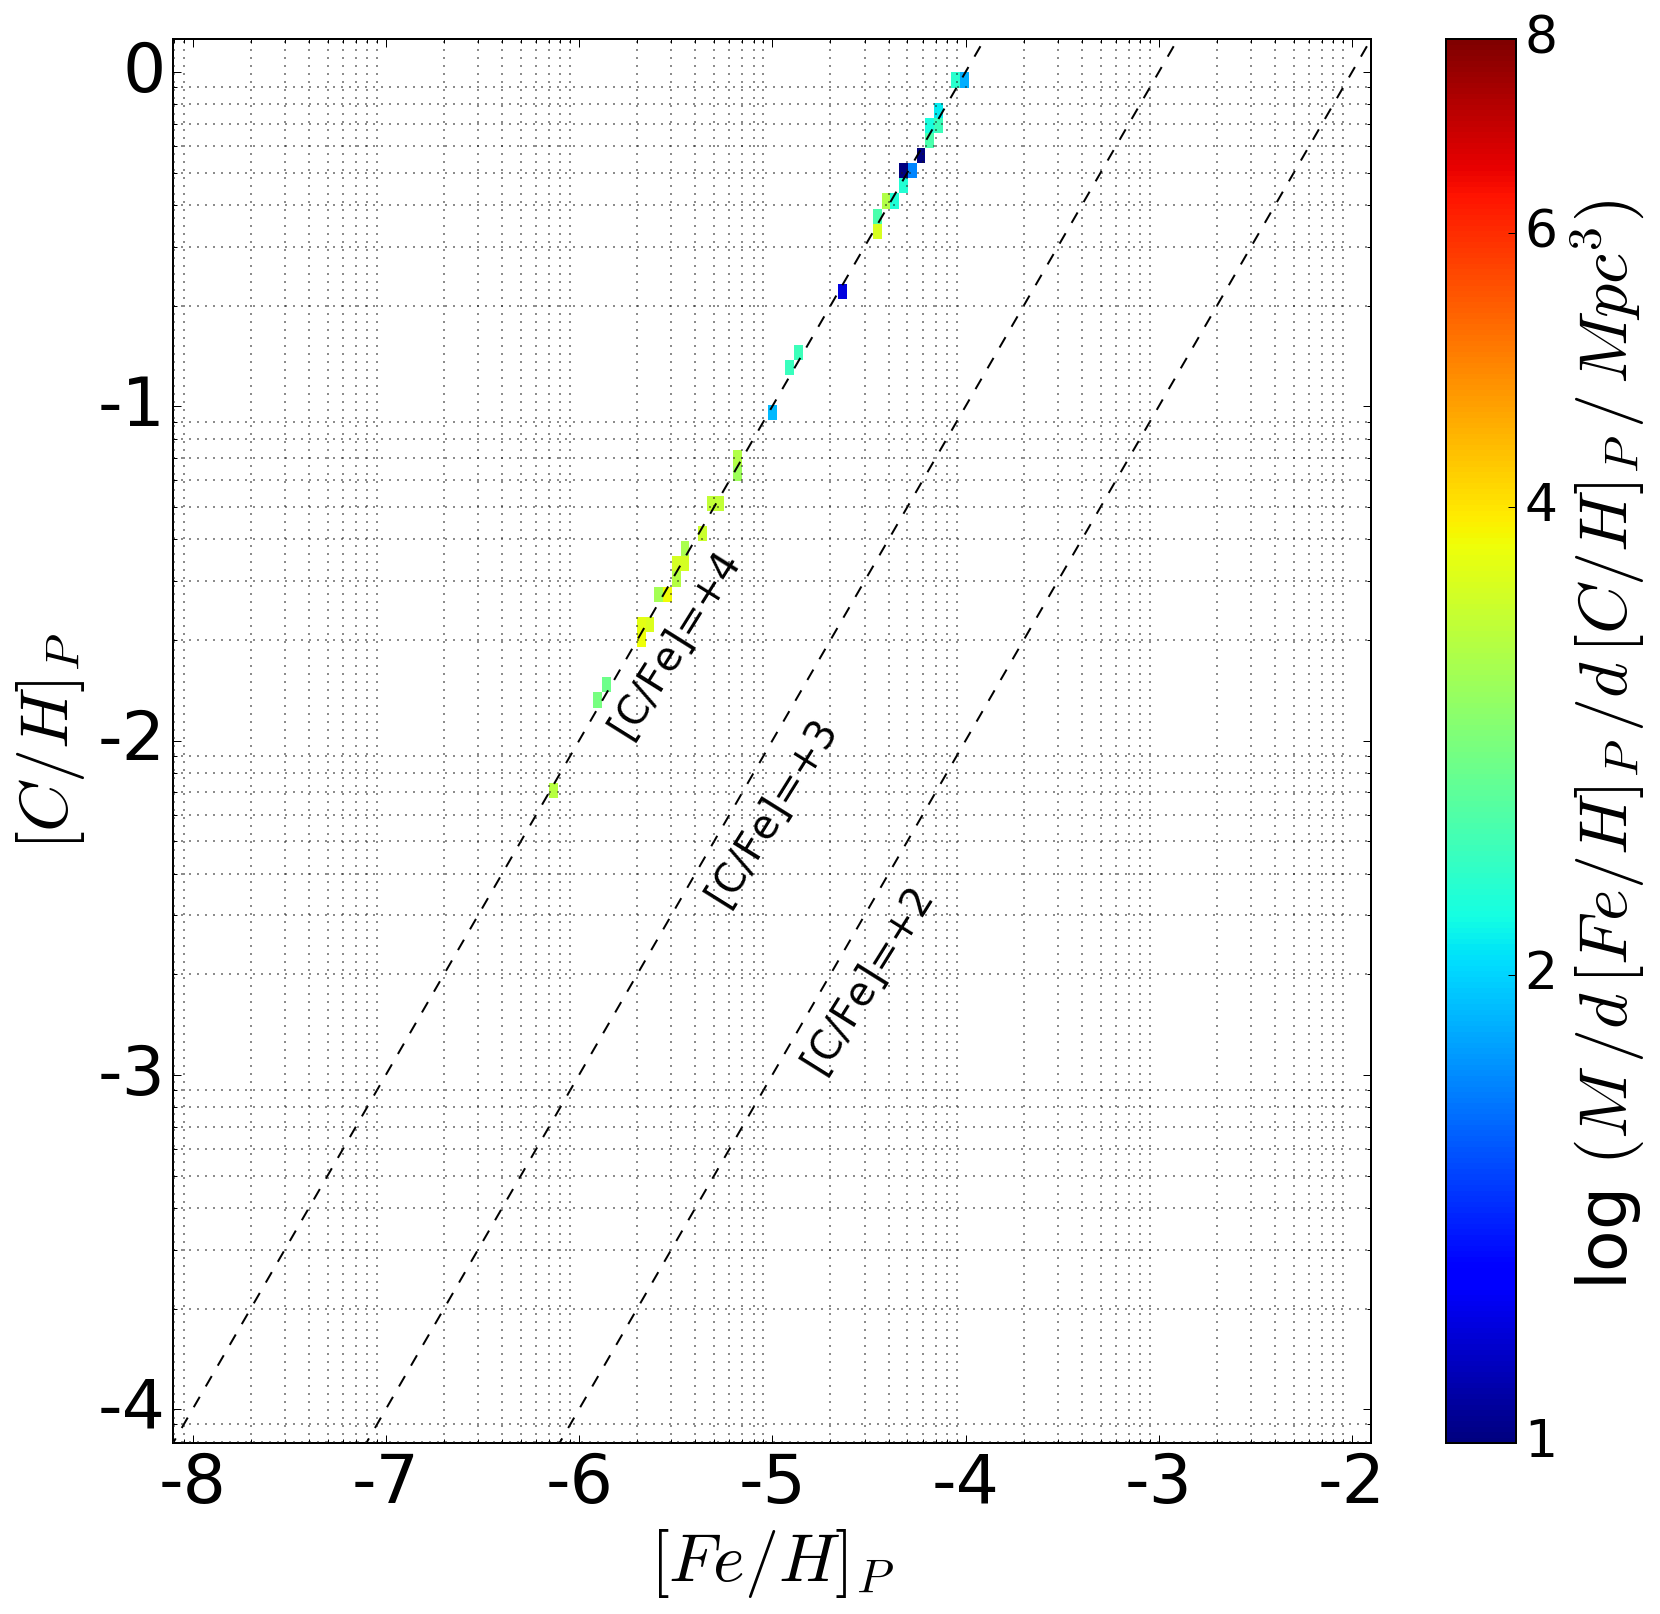

In [179]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]_{P}"
H, xedges, yedges = np.histogram2d(CH/Csun, FeH/Fesun, weights=masses[priStars] * (1.0 - spPF[priStars]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 15))
#axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
cbarMin = 1
cbarMax = 8
histMax = 3

nullfmt = NullFormatter()

ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[C/Fe]=+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.5, 10**-2.5), 
                  horizontalalignment='center',size=20,rotation=58.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('[C/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5, 10**-2), 
                  horizontalalignment='center',size=20,rotation=58.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[C/Fe]=+4', xy=(10**-6.9, 10**-4), xytext=(10**-5.5, 10**-1.5), 
                  horizontalalignment='center',size=20,rotation=58.0)

# All values should be on the +4 line
ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{P}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [1,2,4,6, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{P}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)

# Build the x-axis 1D histogram
# Generate the xy axes histograms
#N, bins, patches = axHistx.hist(FeH/Fesun, bins=xrange, log=True, 
#                                weights=masses[priStars] * (1.0 - spPF[priStars]))
#normBarHeight(bins, patches, cmvol)
#axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
#axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
#axHistx.set_ylim([10.0**1.7,10.0**histMax])     # Constant range for all histograms
#axHistx.tick_params(labelsize=labelsize)
#axHistx.yaxis.set_ticks([1e1, 1e2, 1e3])
#axHistx.grid(color='0.75', linestyle=':', linewidth=2)
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(CH/Csun, bins=yrange, log=True, weights=masses[priStars] * (1.0 - spPF[priStars]),
#                                        orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([10.0**1.7,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e1, 1e2, 1e3])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


In [180]:
gc.collect()

954

/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


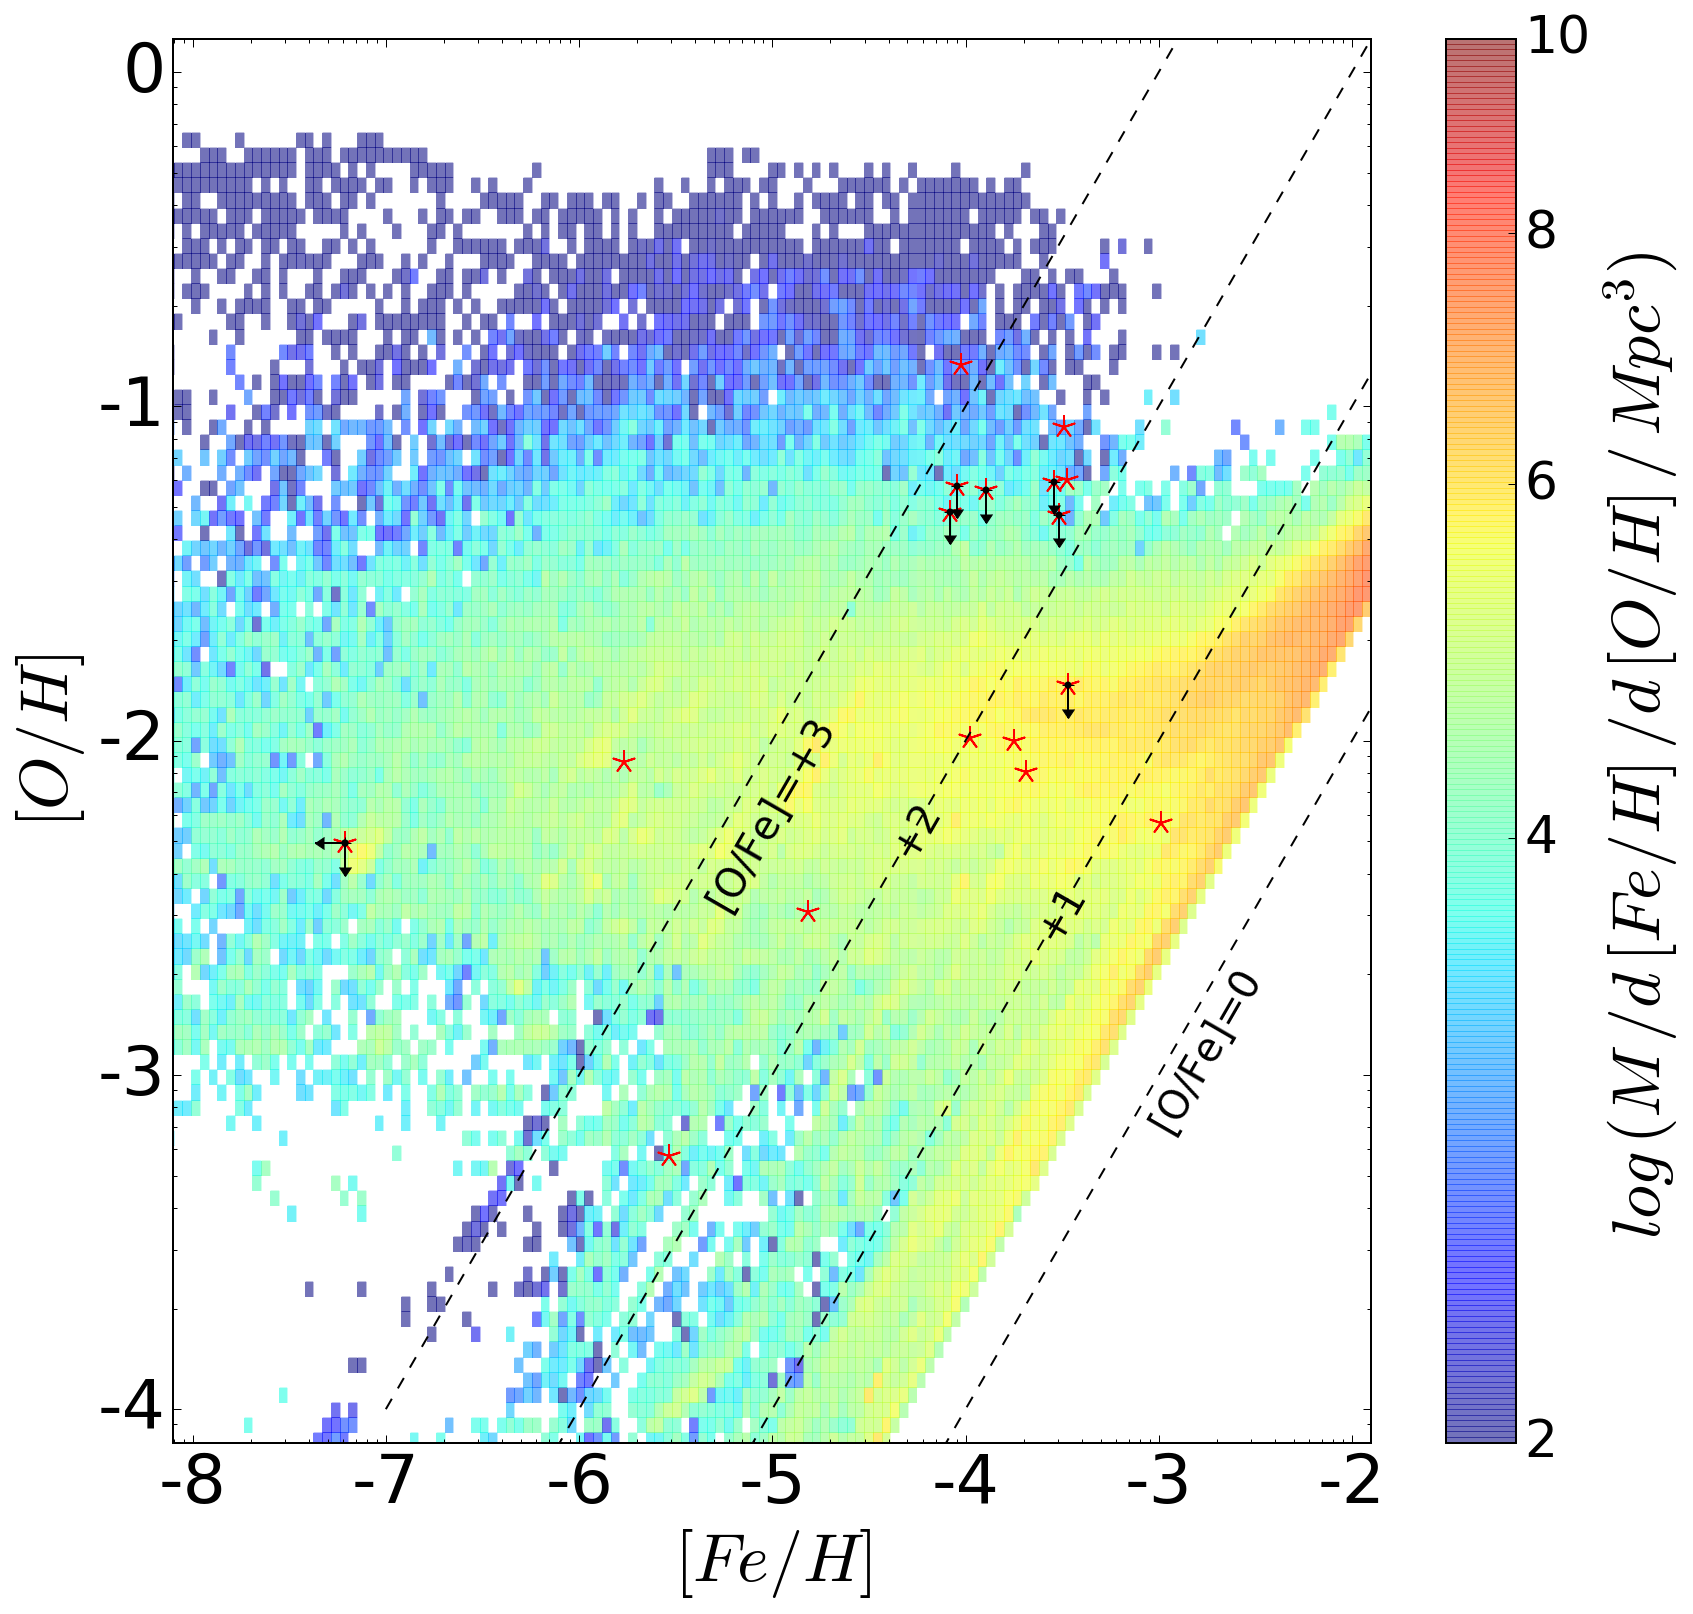

In [181]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[O/H]_{60M_{\odot},1Gyr}\,f_{pol}"
yLabel = "[O/H]"

H, xedges, yedges = np.histogram2d(O_mixedF60/Osun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 15))
#axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}\,f_{pol}$", size=34)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-2.75, 10**-2.75),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-6.9, 10**-4), xytext=(10**-3.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-2.25),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeThree, = ax2dhist.plot(np.array([10**(-7),10**-2]),np.array([10**(-7+3),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.0, 10**-2.0),
                  horizontalalignment='center', size=20,rotation=60.0 ) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[O/H]\, /\, Mpc^{3})$ ", size=34)

# Add Keller CEMP star points
ax2dhist.errorbar(10**np.take(OHFeH,Oindices)[:,0],10**np.take(OHFeH,Oindices)[:,1], fmt='k.', 
                  yerr=0.2*10**np.take(OHFeH,Oindices)[:,1], uplims=True)
ax2dhist.errorbar(10**OHFeH[0,0],10**OHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**OHFeH[0,0], xuplims=True)
ax2dhist.scatter(10**OHFeH[:,0],10**OHFeH[:,1], s=120, c="r" ,marker=(5,2))
#ax2dhist.errorbar(10**OHFeH[:,0], 10**OHFeH[:,1],  )

# Build the x-axis 1D histogram
# Generate the xy axes histograms
#N, bins, patches = axHistx.hist(FeH_mixedF60/Fesun, bins=xrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
#normBarHeight(bins, patches, cmvol)
#axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
#axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
#axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
#axHistx.tick_params(labelsize=labelsize)
#axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
#axHistx.grid(color='0.75', linestyle=':', linewidth=2)
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(OH_mixedF60/Osun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)
plt.savefig("OH60F_fpol.pdf", dpi=fig.dpi)

/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


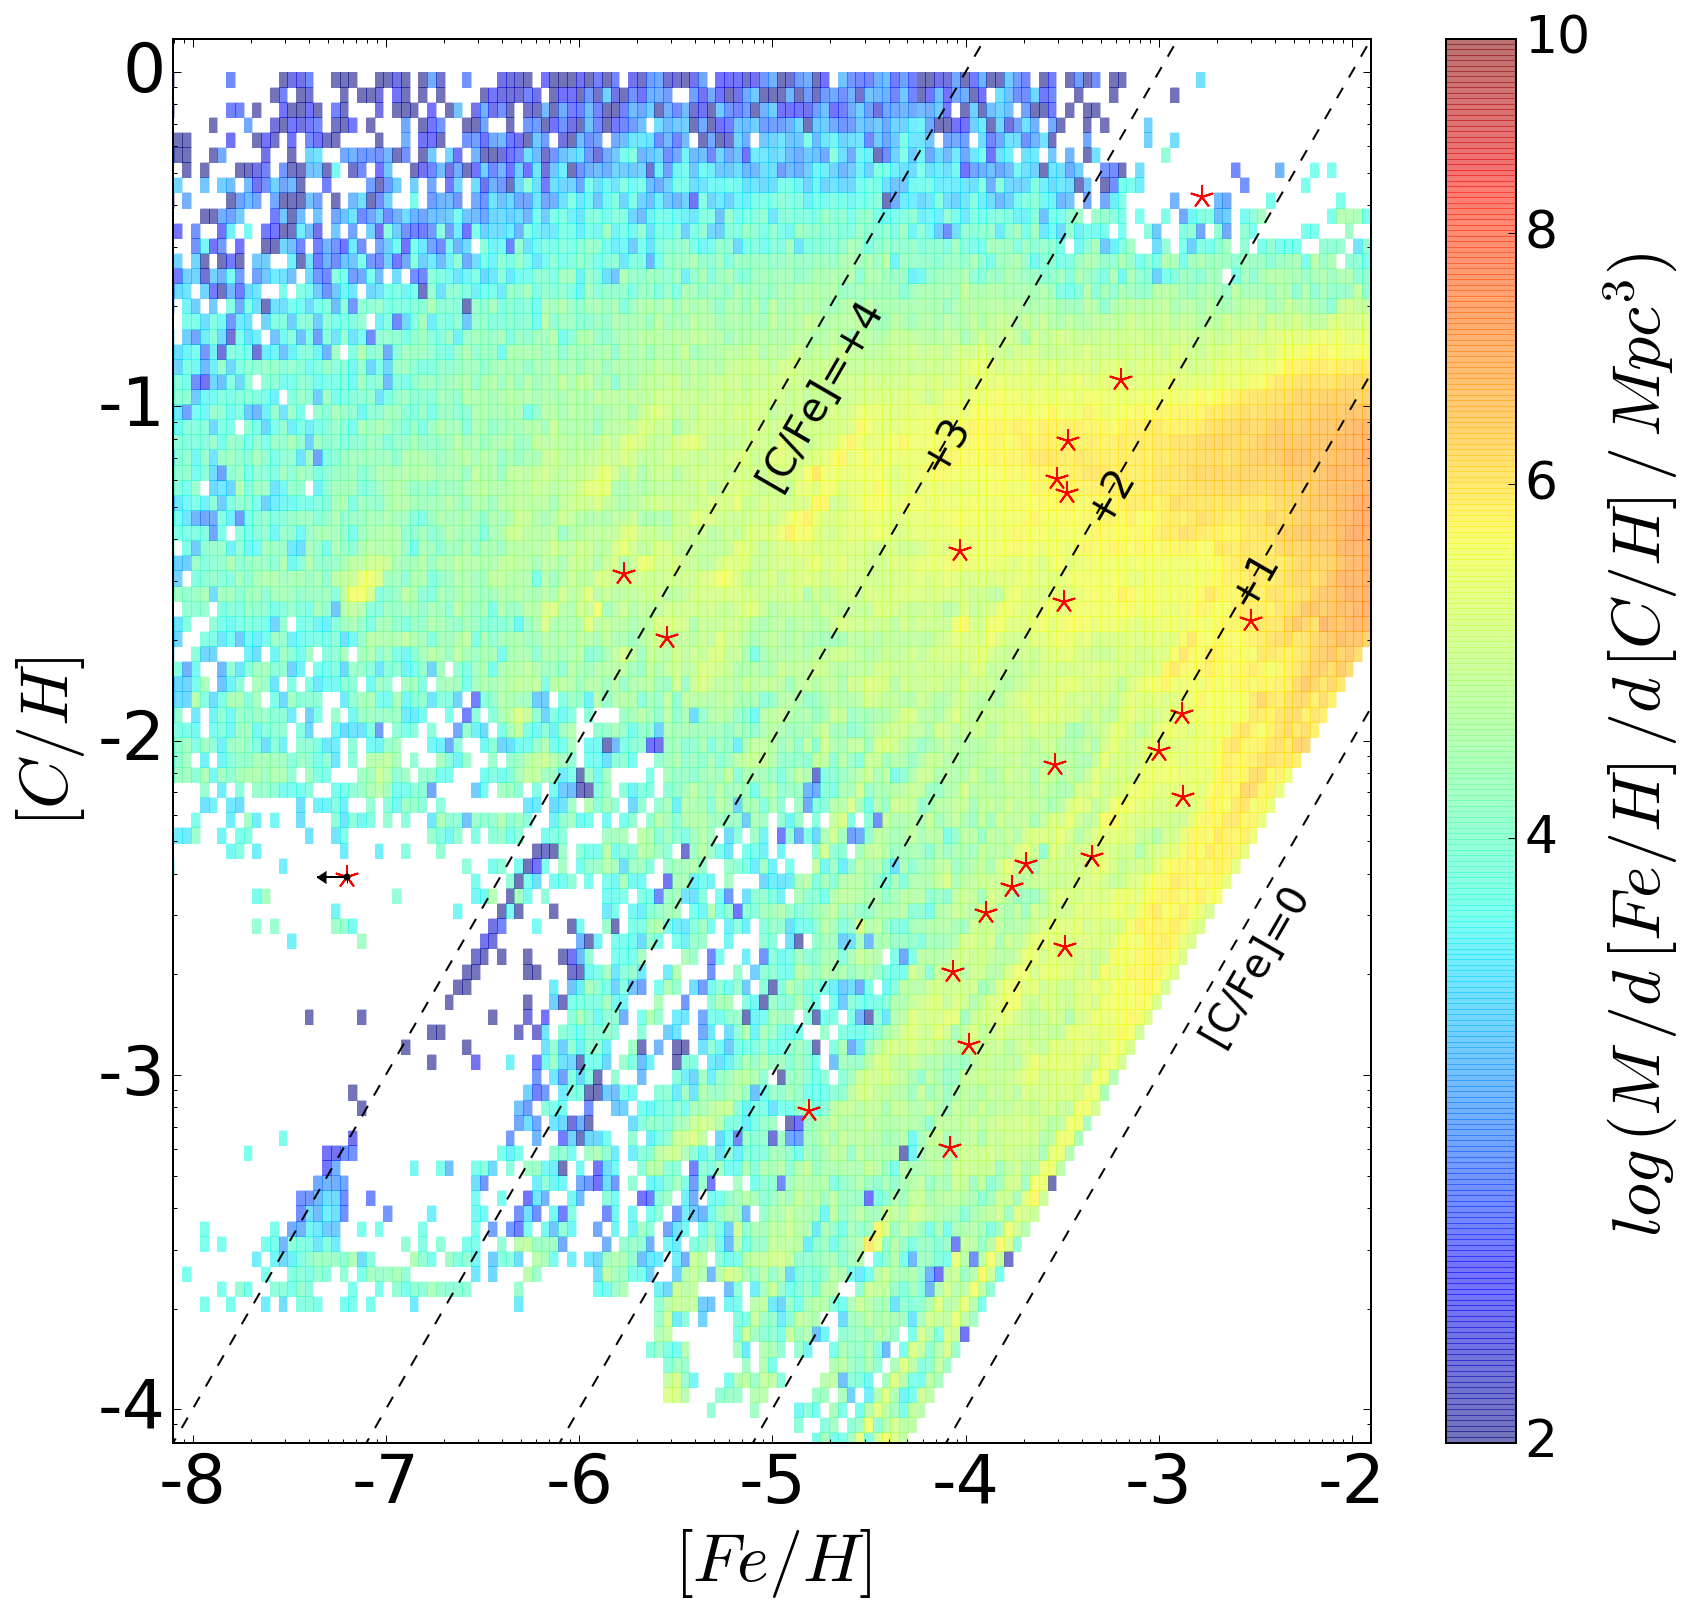

In [200]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]_{60M_{\odot},1Gyr}\,f_{pol}"
yLabel = "[C/H]"
H, xedges, yedges = np.histogram2d(C_mixedF60/Csun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 15))
#axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

histMax = 8
cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}\,f_{pol}$", size=34)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.75, 10**-0.75), 
                  horizontalalignment='center',size=20,rotation=60.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax), alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[C/H]\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

# Add Keller CEMP star points
ax2dhist.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**CHFeH[0,0], xuplims=True)
ax2dhist.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=120, c="r" ,marker=(5,2))


# REMOVE X-axis label/tick labels
#ax2dhist.xaxis.set_ticks([])
#ax2dhist.set_xlabel("")

# Build the x-axis 1D histogram
# Generate the xy axes histograms
#N, bins, patches = axHistx.hist(FeH_mixedF60/Fesun, bins=xrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
#normBarHeight(bins, patches, cmvol)

#axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
#axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
#axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
#axHistx.tick_params(labelsize=labelsize)
#axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
#axHistx.grid(color='0.75', linestyle=':', linewidth=2)
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(CH_mixedF60/Csun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so# x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)
plt.savefig("CH60F_fpol.pdf", dpi=fig.dpi)

In [201]:
gc.collect()

3248

/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


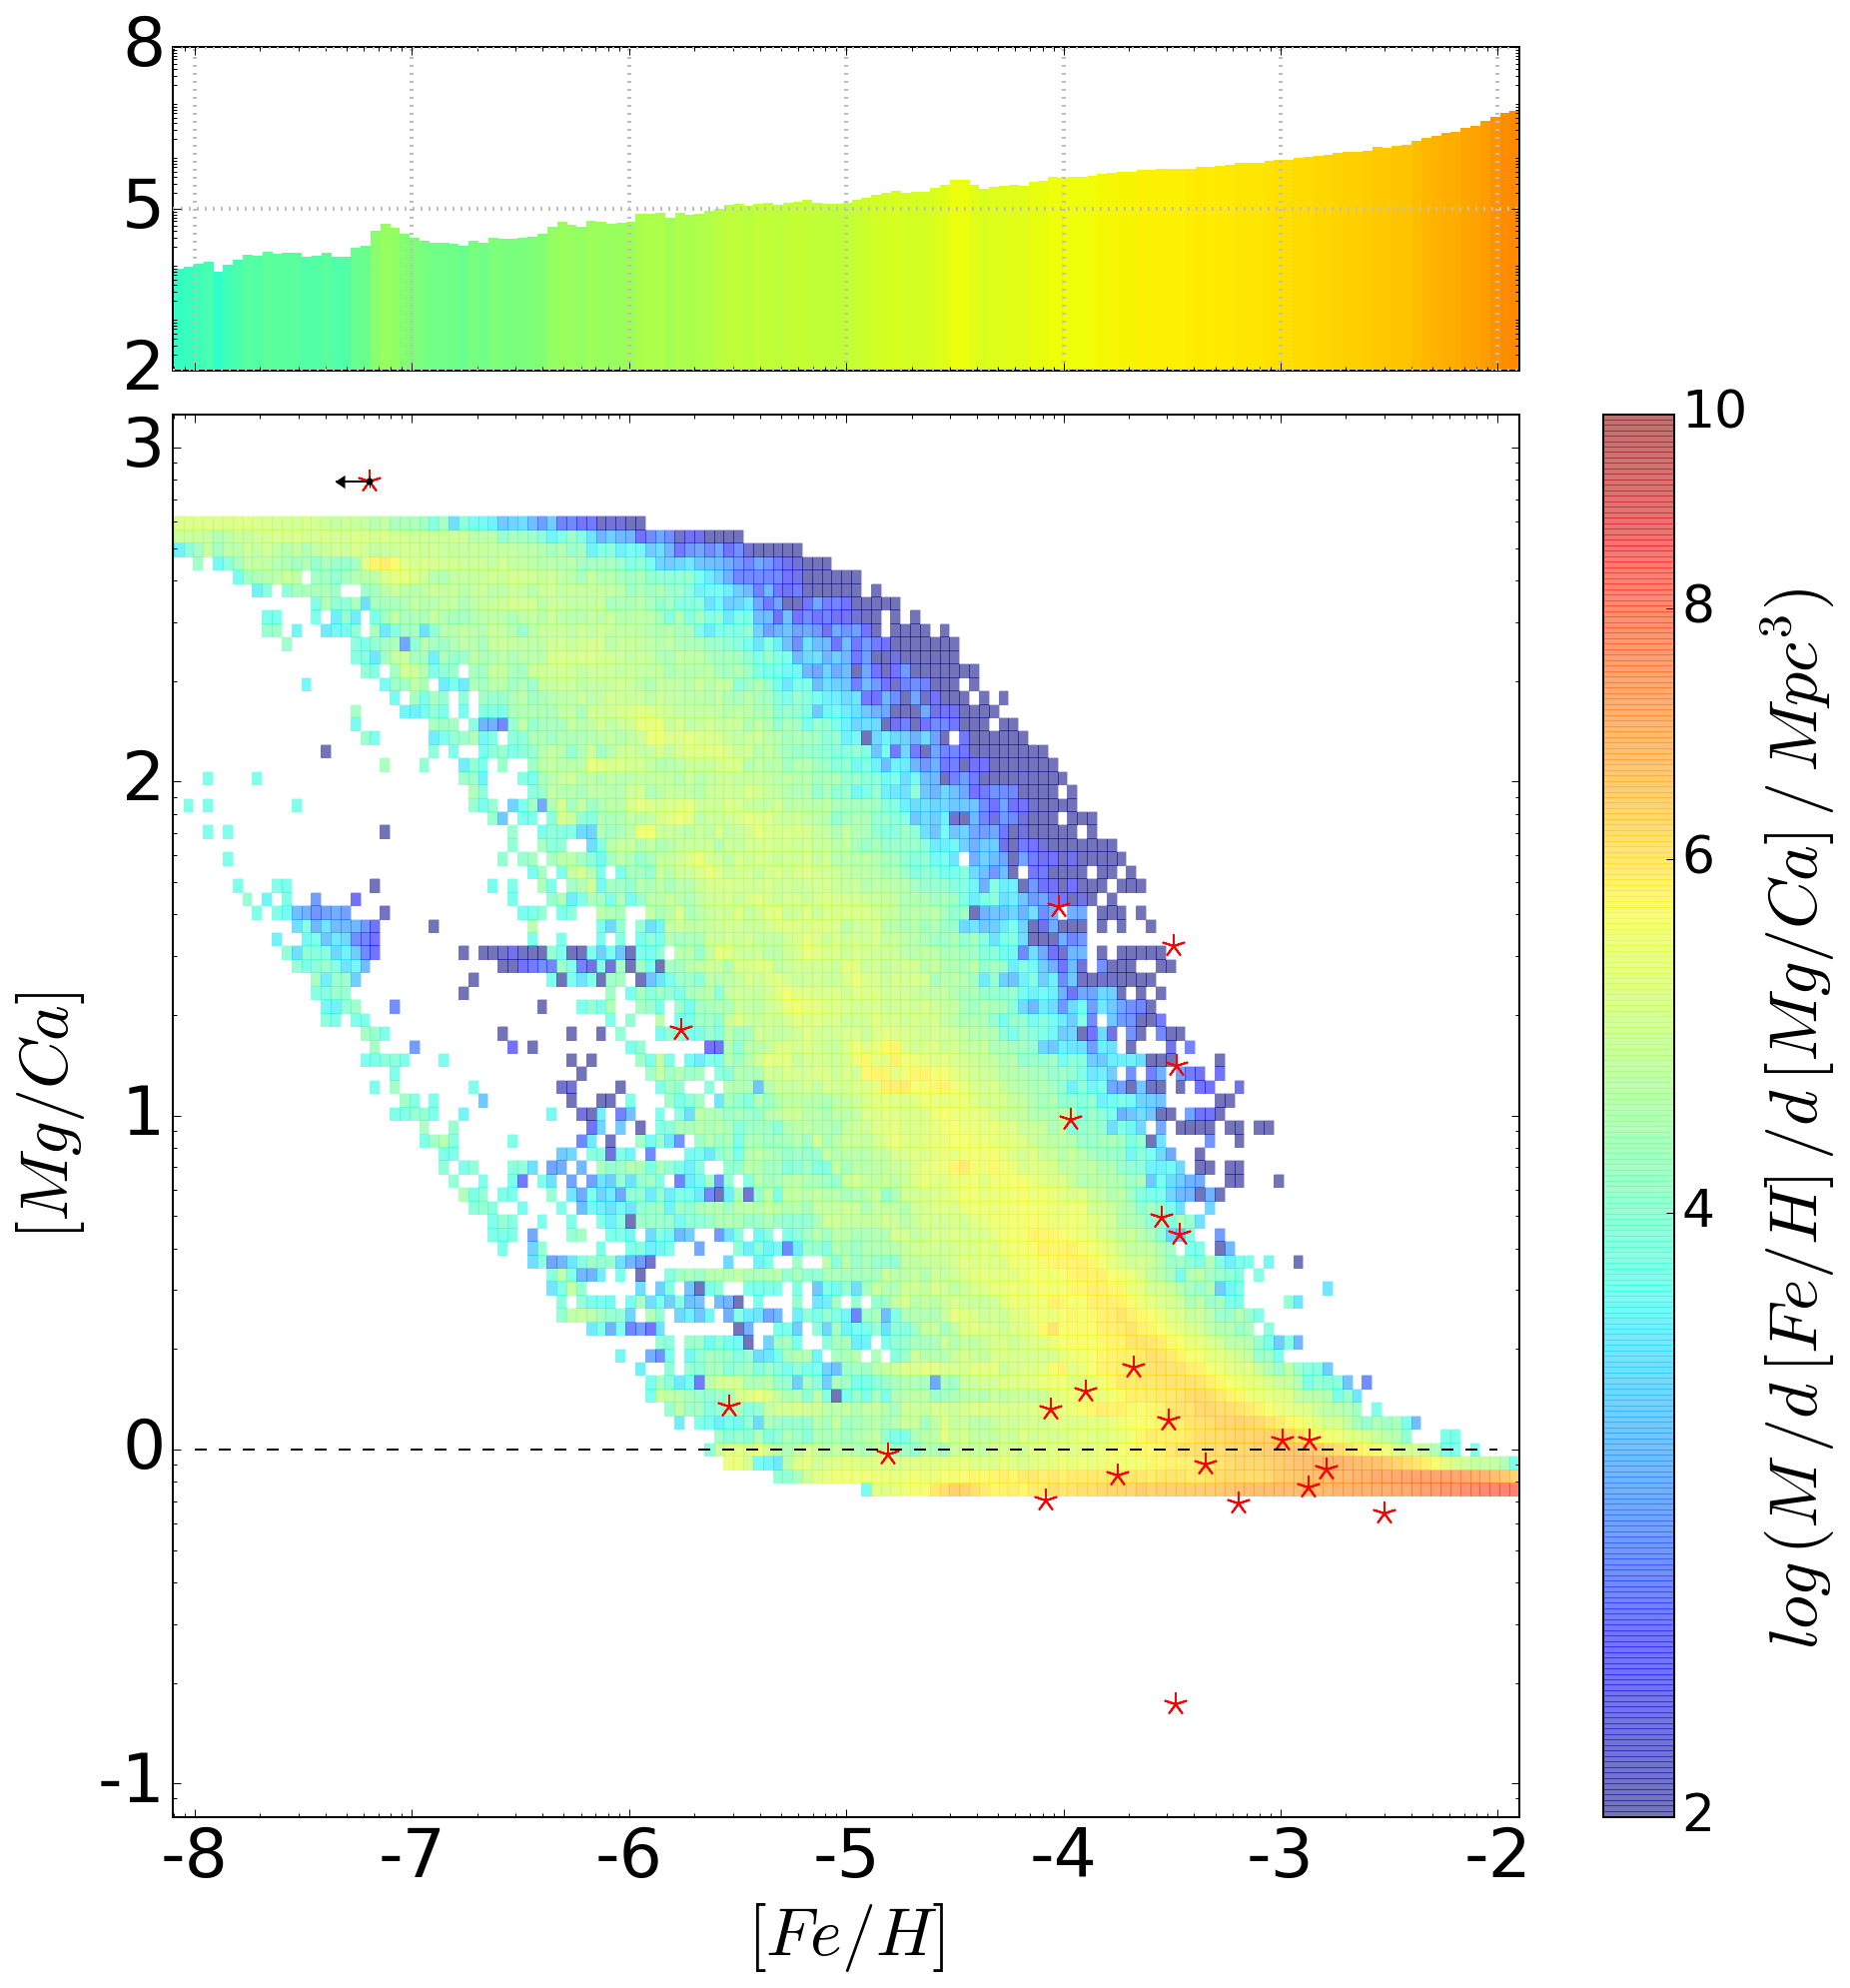

In [199]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-4,4,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[Mg/Ca]_{60M_{\odot},1Gyr}"
yLabel = "[Mg/Ca]"

H, xedges, yedges = np.histogram2d(Mg_mixedF60/Mgsun / (Ca_mixedF60/Casun), Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -1.1; maxY = 3.1
minX = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}$", size=34)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[Mg/Ca]\, /\, Mpc^{3})$ ", size=34)

# Add Keller CEMP star points
ax2dhist.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**MgCaFeH[0,0], xuplims=True)
ax2dhist.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=120, c="r" ,marker=(5,2))


cfeZero,  = ax2dhist.plot(np.array([1e-8,1e-2]),np.array([1,1]), 'k--')

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

# REMOVE X-axis label/tick labels
#ax2dhist.xaxis.set_ticks([])
#ax2dhist.set_xlabel("")

#N, bins, patches = axHisty.hist(OH_mixedF/Osun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)
plt.savefig("MgCa60F_fpol.pdf", dpi=fig.dpi)

In [ ]:
# WITH MDF...

xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[Mg/Ca]_{60M_{\odot},1Gyr}"
yLabel = "[Mg/Ca]"

H, xedges, yedges = np.histogram2d(Mg_mixedF60/Mgsun - (Ca_mixedF60/Casun), Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -8.1; maxY = 3.1
minX = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}$", size=34)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[Mg/Ca]\, /\, Mpc^{3})$ ", size=34)

# Add Keller CEMP star points
ax2dhist.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**MgCaFeH[0,0], xuplims=True)
ax2dhist.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=120, c="r" ,marker=(5,2))

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

# REMOVE X-axis label/tick labels
#ax2dhist.xaxis.set_ticks([])
#ax2dhist.set_xlabel("")

#N, bins, patches = axHisty.hist(OH_mixedF/Osun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)
plt.savefig("MgCa60F_fpol.pdf", dpi=fig.dpi)

In [ ]:
temp=Mg_mixedF60/Mgsun - (Ca_mixedF60/Casun)
fe = Fe_mixedF60/Fesun

In [ ]:
(temp[fe>-3]/fe[fe>-3])[temp[fe>-3]/fe[fe>-3] > 0]

In [ ]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[N/H]_{60M_{\odot},1Gyr}\,f_{pol}"
H, xedges, yedges = np.histogram2d(N_mixedF60/Nsun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 15))
#axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

histMax = 8
cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}\,f_{pol}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[N/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[N/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-5.0, 10**-1.0), 
                  horizontalalignment='center',size=20,rotation=60.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax), alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[N/H]\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

# Add Keller CEMP star points
#ax2dhist.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', 
#                  xerr=3e-1*10**CHFeH[0,0], xuplims=True)
#ax2dhist.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=120, c="r" ,marker=(5,2))

# Build the x-axis 1D histogram
# Generate the xy axes histograms
#N, bins, patches = axHistx.hist(FeH_mixedF60/Fesun, bins=xrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
#normBarHeight(bins, patches, cmvol)

#axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
#axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
#axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
#axHistx.tick_params(labelsize=labelsize)
#axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
#axHistx.grid(color='0.75', linestyle=':', linewidth=2)
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(CH_mixedF60/Csun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so# x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


In [ ]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[N/H]_{1Gyr}"
H, xedges, yedges = np.histogram2d(NH_mixedF/Nsun, FeH_mixedF/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(18, 15))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

histMax = 8
cbarMin = 4
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{1Gyr}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[N/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=56.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('[N/Fe]=+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=57.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('[N/Fe]=+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=57.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax)))
cbarticks = [4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]_{1Gyr}\, / d\,"+yLabel+"\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

# Build the x-axis 1D histogram
# Generate the xy axes histograms
#N, bins, patches = axHistx.hist(FeH_mixedF/Fesun, bins=xrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
#normBarHeight(bins, patches, cmvol)

#axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
#axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
#axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
#axHistx.tick_params(labelsize=labelsize)
#axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
#axHistx.grid(color='0.75', linestyle=':', linewidth=2)
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(CH_mixedF/Csun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so# x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)


# Try more resolution... 

In [ ]:
xrange = np.logspace(-9,0,400)
yrange = np.logspace(-9,0,400)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]_{60M_{\odot},1Gyr}\,f_{pol}"
yLabel = "[C/H]"
H, xedges, yedges = np.histogram2d(C_mixedF60/Csun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 15))
#axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

histMax = 8
cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}\,f_{pol}$", size=34)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.75, 10**-0.75), 
                  horizontalalignment='center',size=20,rotation=60.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax), alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[C/H]\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

# Add Keller CEMP star points
ax2dhist.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**CHFeH[0,0], xuplims=True)
ax2dhist.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=120, c="r" ,marker=(5,2))


# REMOVE X-axis label/tick labels
ax2dhist.xaxis.set_ticks([])
ax2dhist.set_xlabel("")

# Build the x-axis 1D histogram
# Generate the xy axes histograms
#N, bins, patches = axHistx.hist(FeH_mixedF60/Fesun, bins=xrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
#normBarHeight(bins, patches, cmvol)

#axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
#axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
#axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
#axHistx.tick_params(labelsize=labelsize)
#axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
#axHistx.grid(color='0.75', linestyle=':', linewidth=2)
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(CH_mixedF60/Csun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so# x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)
plt.savefig("CH60F_fpol-hiRes.pdf", dpi=fig.dpi)

#All Plots on one

In [ ]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[Mg/Ca]"

H, xedges, yedges = np.histogram2d(MgH_mixedF60/Mgsun / (Ca_mixedF60/Casun), Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

#fig = plt.figure(figsize=(18, 15))
fig, (axHistx,ax1, ax2, ax3) = plt.subplots(4, sharex=True, sharey=False)

axHistx = plt.axes(rect_histx)
ax1 = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -1.1; maxY = 3.1
minX = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax1.tick_params(axis='y', labelsize=labelsize)
ax1.set_xlabel("", size=34) # NO LABEL ON X
ax1.set_ylabel("$"+yLabel+"$", size=34)
    
ax1.set_xlim([10**minX,10**maxX])
ax1.set_ylim([10**minY,10**maxY])
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)

ax1.xaxis.set_major_formatter(custom_formatter)
ax1.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
ax1.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**MgCaFeH[0,0], xuplims=True)
ax1.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=120, c="r" ,marker=(5,2))

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(FeH_mixedF60/Fesun, bins=xrange, log=True, 
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks


X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]"
H, xedges, yedges = np.histogram2d(C_mixedF60/Csun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

histMax = 8
cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ax2 = plt.axes(rect_2dhist)

ax2.tick_params(axis='x', labelsize=labelsize)
ax2.tick_params(axis='y', labelsize=labelsize)
ax2.set_xlabel("", size=34) # NO LABEL ON X
ax2.set_ylabel("$"+yLabel+"$", size=34)
    
ax2.set_xlim([10**minX,10**maxX])
ax2.set_ylim([10**minY,10**maxY])
ax2.set_xscale('log')
ax2.set_yscale('log')

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.75, 10**-0.75), 
                  horizontalalignment='center',size=20,rotation=60.0)

ax2.xaxis.set_major_formatter(custom_formatter)
ax2.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
ax2.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**CHFeH[0,0], xuplims=True)
ax2.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=120, c="r" ,marker=(5,2))



X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[O/H]"

H, xedges, yedges = np.histogram2d(O_mixedF60/Osun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)


minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax3 = plt.axes(rect_2dhist)

ax3.tick_params(axis='x', labelsize=labelsize)
ax3.tick_params(axis='y', labelsize=labelsize)
ax3.set_xlabel("$[Fe/H]", size=34)
ax3.set_ylabel("$"+yLabel+"$", size=34)
    
ax3.set_xlim([10**minX,10**maxX])
ax3.set_ylim([10**minY,10**maxY])
ax3.set_xscale('log')
ax3.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax3.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-2.75, 10**-2.75),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax3.annotate('+1', xy=(10**-6.9, 10**-4), xytext=(10**-3.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax3.annotate('+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-2.25),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeThree, = ax2dhist.plot(np.array([10**(-7),10**-2]),np.array([10**(-7+3),10**(1)]), 'k--')
ax3.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.0, 10**-2.0),
                  horizontalalignment='center', size=20,rotation=60.0 ) 

ax3.xaxis.set_major_formatter(custom_formatter)
ax3.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[X/H]\, /\, Mpc^{3})$ ", size=34)

# Add Keller CEMP star points
ax3.errorbar(10**np.take(OHFeH,Oindices)[:,0],10**np.take(OHFeH,Oindices)[:,1], fmt='k.', 
                  yerr=0.2*10**np.take(OHFeH,Oindices)[:,1], uplims=True)
ax3.errorbar(10**OHFeH[0,0],10**OHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**OHFeH[0,0], xuplims=True)
ax3.scatter(10**OHFeH[:,0],10**OHFeH[:,1], s=120, c="r" ,marker=(5,2))

plt.show()
#plt.savefig("metals_fpol.pdf", dpi=fig.dpi)

In [ ]:
min(FeH_mixedF25/Fesun),max(FeH_mixedF25/Fesun)

In [ ]:
min(OH_mixedF25/Osun),max(OH_mixedF25/Osun)

In [ ]:
xrange = np.logspace(-9,0,200)
yrange = np.logspace(-9,0,200)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[O/H]_{25M_{\odot},1Gyr}/f_{pol}"

H, xedges, yedges = np.histogram2d(FeH_mixedF25/Fesun, OH_mixedF25/Osun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 15))
#axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
minX = -4.1; maxY = 0.1
minY = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{25M_{\odot},1Gyr}/f_{pol}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-2.75, 10**-2.75),
                  horizontalalignment='center',size=20,rotation=59.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-6.9, 10**-4), xytext=(10**-3.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=59.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-2.25),
                  horizontalalignment='center',size=20,rotation=59.0 ) 
cfeThree, = ax2dhist.plot(np.array([10**(-7),10**-2]),np.array([10**(-7+3),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.0, 10**-2.0),
                  horizontalalignment='center', size=20,rotation=59.0 ) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M\, / d\,[Fe/H]\, / d\,[O/H]\, /\, Mpc^{3})$ ", size=34)

# Add Keller CEMP star points
ax2dhist.errorbar(10**np.take(OHFeH,Oindices)[:,0],10**np.take(OHFeH,Oindices)[:,1], fmt='k.', 
                  yerr=0.2*10**np.take(OHFeH,Oindices)[:,1], uplims=True)
ax2dhist.errorbar(10**OHFeH[0,0],10**OHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**OHFeH[0,0], xuplims=True)
ax2dhist.scatter(10**OHFeH[:,0],10**OHFeH[:,1], s=120, c="r" ,marker=(5,2))
#ax2dhist.errorbar(10**OHFeH[:,0], 10**OHFeH[:,1],  )

# Build the x-axis 1D histogram
# Generate the xy axes histograms
#N, bins, patches = axHistx.hist(FeH_mixedF25/Fesun, bins=xrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
#normBarHeight(bins, patches, cmvol)
#axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
#axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
#axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
#axHistx.tick_params(labelsize=labelsize)
#axHistx.yaxis.set_ticks([1e2, 1e5, 1e8])
#axHistx.grid(color='0.75', linestyle=':', linewidth=2)
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

#N, bins, patches = axHisty.hist(OH_mixedF/Osun, bins=yrange, log=True, 
#                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), orientation='horizontal')
#normBarHeight(bins, patches, cmvol, rotated=True)
#axHisty.set_yscale('log')
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

#axHisty.set_xlim([1e2,10.0**histMax])     # We're rotated, so x axis is the value
#axHisty.set_ylim([10**minY,10**maxY])  # Match the y range on the vert hist
#axHisty.tick_params(labelsize=labelsize)
#axHisty.xaxis.set_ticks([1e2, 1e5, 1e8])
#axHisty.grid(color='0.75', linestyle=':', linewidth=2)
#axHisty.xaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHisty.yaxis.set_major_formatter(nullfmt)
plt.savefig("OH25F_fpol.pdf", dpi=fig.dpi)